In [4]:
import numpy as np
import pandas as pd
from sklearn import neighbors
from sklearn.model_selection import KFold, 
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, roc_curve
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing


In [36]:
def evaluate_model(model, X_train, y_train, cv, debug = False):
    list_specificity = []
    list_sensibility = []
    scores = cross_validate(model, X_train, y_train, scoring='accuracy', cv = cv, n_jobs=-1, return_estimator=True)
    estimators = scores['estimator']
    print(f"Accuracy: {np.mean(scores['test_score'])}\n\n")

    if (debug):
        for i, (train_index, test_index) in enumerate(cv.split(X_train)):
    
            X_pred = X_train[test_index]
            y_ground = y_train[test_index]
            y_pred = estimators[0].predict(X_pred)
            tn, fp, fn, tp = confusion_matrix(y_ground, y_pred).ravel()
            sensibility = tp / (tp + fn)
            specificity = tn / (tn + fp)
            list_sensibility.append(sensibility)
            list_specificity.append(specificity)
    
            print(f"Fold {i}")
            print(f'Number of samples: {len(X_pred)}')
            print(f"Mean Specificity= {specificity}")
            print(f"Mean Sensibility= {sensibility}\n\n")
  
            ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_ground, y_pred), display_labels=['Non Infart', 'Infart']).plot()
            plt.grid(False)
            plt.show()
    
        print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
        print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
    return estimators

In [40]:
def evaluate_kfold(list_of_estimators, X_total, y_total):
    # Verificando a media com todos os elementos e classificadores
    list_sensibility = []
    list_specificity = []
    list_of_false_positives_rate = []

    for i, estimator in enumerate(list_of_estimators):
        X_pred = X_total
        y_truth = y_total
        y_pred = estimator.predict(X_pred)
        tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
        sensibility = tp / (tp + fn)
        specificity = tn / (tn + fp)
        false_pos_rate = 1 - specificity

        print(f'Number of samples: {len(X_pred)}')
        print(f"Specificity= {specificity}")
        print(f"Sensibility= {sensibility}")
        print(f"False positive rate = {false_pos_rate}\n\n")

        list_sensibility.append(sensibility)
        list_specificity.append(specificity)
        list_of_false_positives_rate.append(false_pos_rate)
  
        ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
        RocCurveDisplay.from_predictions(y_truth, y_pred, pos_label=1)
        plt.grid(True)
        plt.show()

    print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
    print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")
    print(f"Mean False Positive Rate= {np.mean(list_of_false_positives_rate)}  Std: {np.std(list_of_false_positives_rate)}")


In [7]:
# Seed
seed = 12345

In [8]:
df = pd.read_csv('../data/complete_dataset.csv', index_col=0)

In [9]:
df.head()

corrente_anodica  corrente_catodica       carga  \
0        111.206245        -128.070497  582.026580   
1        117.477703        -132.831311  554.636573   
2        111.984444        -133.417261  636.900253   
3        114.831800        -148.762000  497.157678   
4        100.741600        -122.019000  609.328195   

   diff_corrente_anodica_catodica  diff_pot_anodico_catodico  \
0                      239.276743                   0.205634   
1                      250.309014                   0.199645   
2                      245.401704                   0.193656   
3                      263.593800                   0.187666   
4                      222.760600                   0.183673   

   pico_derivada_anodica  pico_derivada_catodica  target  
0              84.763748              -89.000926       1  
1              88.426733              -92.060480       1  
2              87.221721              -93.731053       1  
3              96.151949             -108.130415       1  
4              83.015207              -90.556571       1

In [10]:
df.tail()

corrente_anodica  corrente_catodica       carga  \
50         93.579555        -142.099047  703.929038   
51          0.000000        -129.023850  629.446398   
52        107.623529        -130.686378  546.450781   
53         85.166931        -104.910982  686.594488   
54         85.041928        -109.342301  665.782497   

    diff_corrente_anodica_catodica  diff_pot_anodico_catodico  \
50                      235.678601                   0.192003   
51                        0.000000                   0.000000   
52                      238.309908                   0.188003   
53                      190.077913                   0.188003   
54                      194.384229                   0.192003   

    pico_derivada_anodica  pico_derivada_catodica  target  
50              77.378071              -99.576142       0  
51              65.455168              -90.572485       0  
52              82.729708              -88.611173       0  
53              67.804083              -74.661710       0  
54              64.283984              -73.564895       0

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 0 to 54
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   corrente_anodica                55 non-null     float64
 1   corrente_catodica               55 non-null     float64
 2   carga                           55 non-null     float64
 3   diff_corrente_anodica_catodica  55 non-null     float64
 4   diff_pot_anodico_catodico       55 non-null     float64
 5   pico_derivada_anodica           55 non-null     float64
 6   pico_derivada_catodica          55 non-null     float64
 7   target                          55 non-null     int64  
dtypes: float64(7), int64(1)
memory usage: 3.9 KB


In [12]:
df.head()

corrente_anodica  corrente_catodica       carga  \
0        111.206245        -128.070497  582.026580   
1        117.477703        -132.831311  554.636573   
2        111.984444        -133.417261  636.900253   
3        114.831800        -148.762000  497.157678   
4        100.741600        -122.019000  609.328195   

   diff_corrente_anodica_catodica  diff_pot_anodico_catodico  \
0                      239.276743                   0.205634   
1                      250.309014                   0.199645   
2                      245.401704                   0.193656   
3                      263.593800                   0.187666   
4                      222.760600                   0.183673   

   pico_derivada_anodica  pico_derivada_catodica  target  
0              84.763748              -89.000926       1  
1              88.426733              -92.060480       1  
2              87.221721              -93.731053       1  
3              96.151949             -108.130415       1  
4              83.015207              -90.556571       1

### Spearman correlation

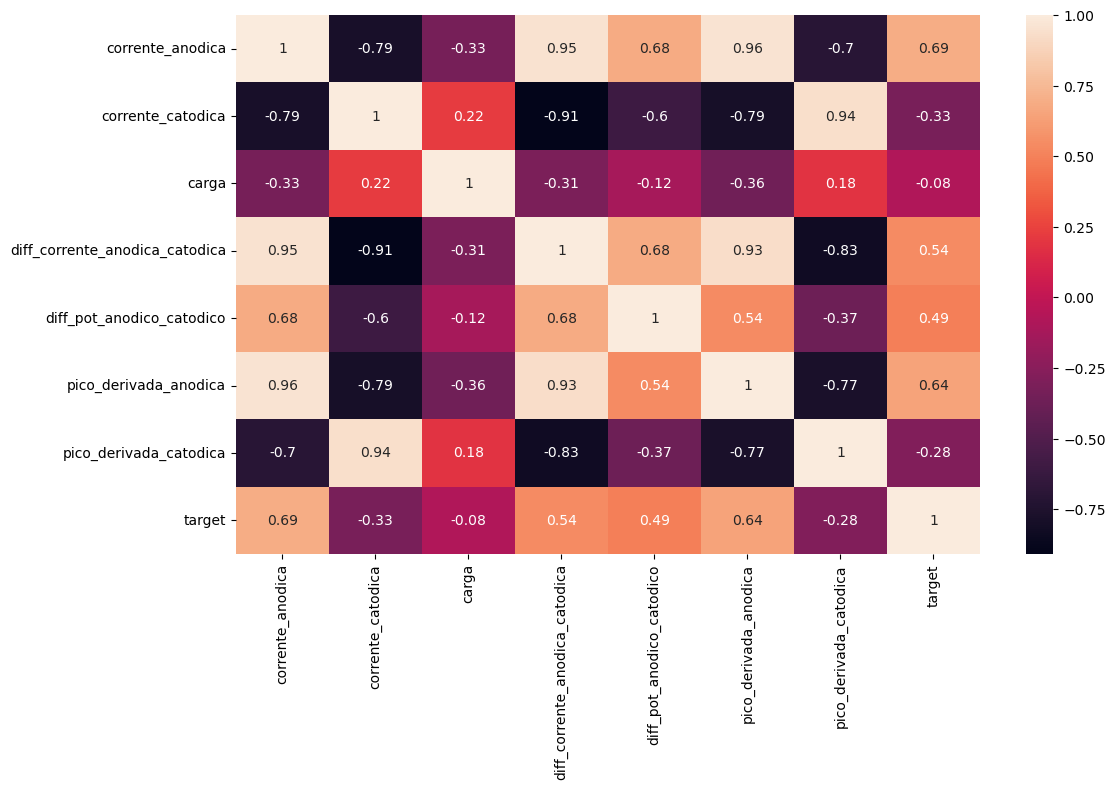

In [19]:
fig, ax = plt.subplots(figsize=(12,7))
ax = sns.heatmap(df.corr(method='spearman'), annot=True)
plt.show()

In [14]:
# Funçao para plotar grafico de dispersão
def plot_dispersion_graph(X, target, variable = 'Independent Variable'):
    fig, ax = plt.subplots(figsize=(5,5))
    for i, x in enumerate(X):
        # Positives
        if target.values[i] == 1:
            ax.scatter(X.values[i], target.values[i], marker='o', color='r')
        # Negatives
        else:
            ax.scatter(X.values[i], target.values[i], marker='o', color='b')
            
    ax.set_ylabel("Target")
    ax.set_xlabel(variable)
    ax.set_title(variable + " Dispersion Grapgh")
    plt.show()

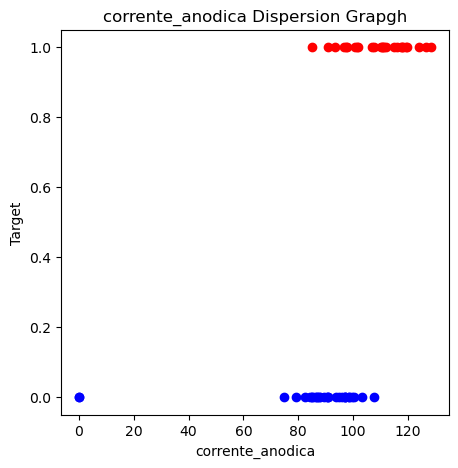

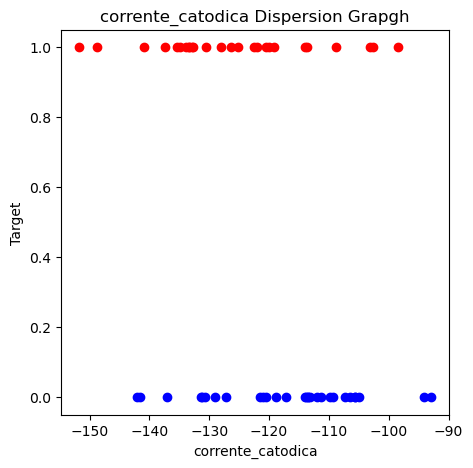

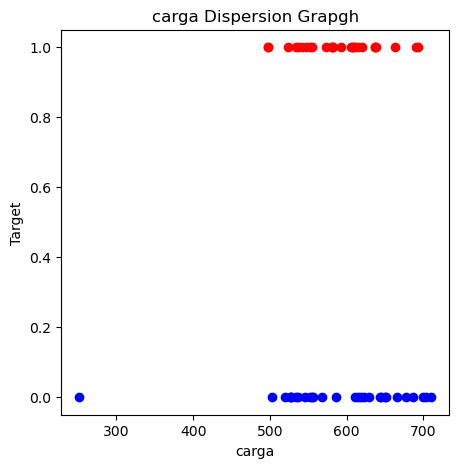

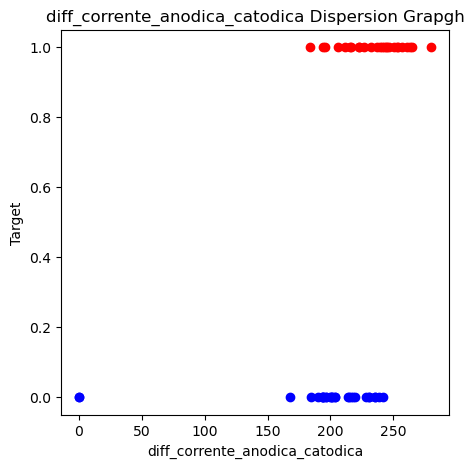

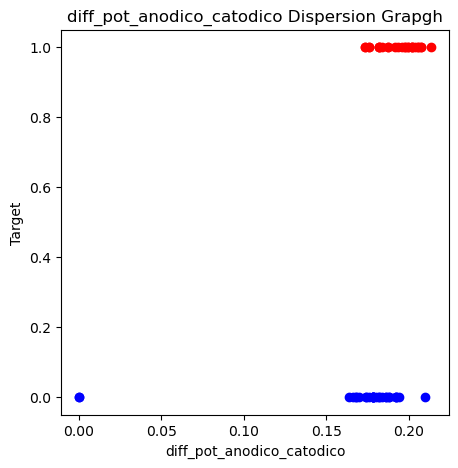

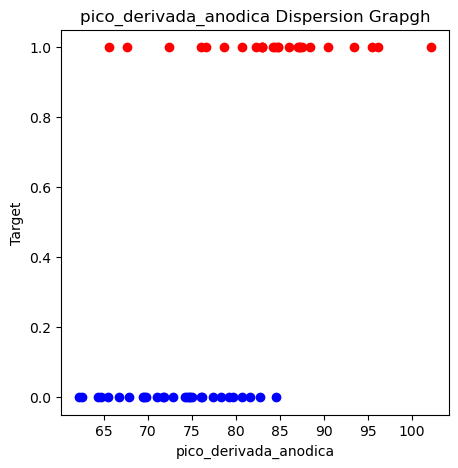

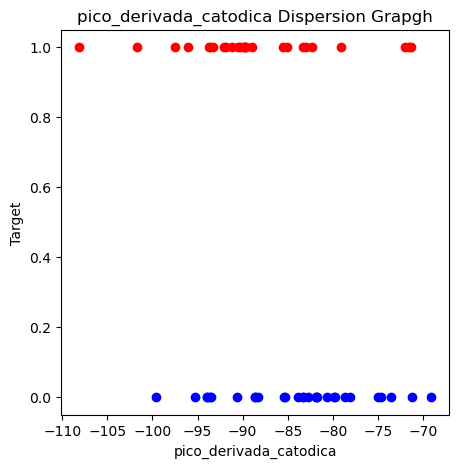

In [15]:
target = df['target']
features = df.iloc[:,:-1]

for feature in features.columns:
    plot_dispersion_graph(df[feature], target, feature)

In [25]:
# Preparando os dados
X = df.iloc[:,:-1]
#X.drop(['carga'], axis=1)
y = df['target']

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X.values)

cv = KFold(n_splits = len(X), random_state=seed, shuffle=True)
#Create a model for logistic regression
model = LogisticRegression(max_iter=1000)
scores = cross_validate(model, X_train, y.values, scoring='accuracy', cv = cv, n_jobs=-1, return_estimator=True)
print("Acurracy {n}".format(n = np.mean(np.mean(scores['test_score']))))

Acurracy 0.8909090909090909


Fold 0
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 0.8333333333333334




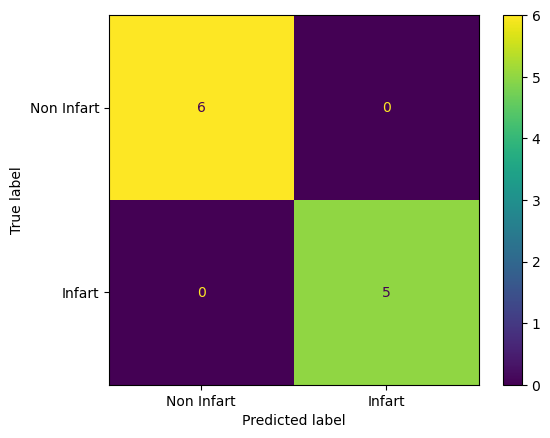

Fold 1
Number of samples: 11
Mean Specificity= 0.875
Mean Sensibility= 0.6666666666666666




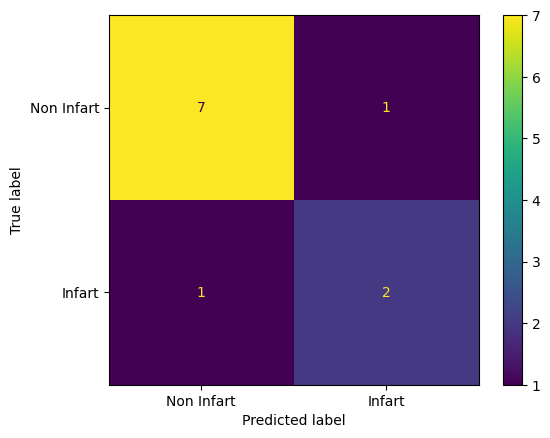

Fold 2
Number of samples: 11
Mean Specificity= 0.8571428571428571
Mean Sensibility= 1.0




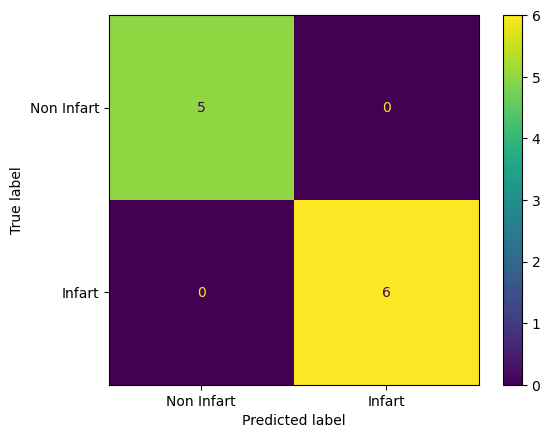

Fold 3
Number of samples: 11
Mean Specificity= 0.8
Mean Sensibility= 0.8333333333333334




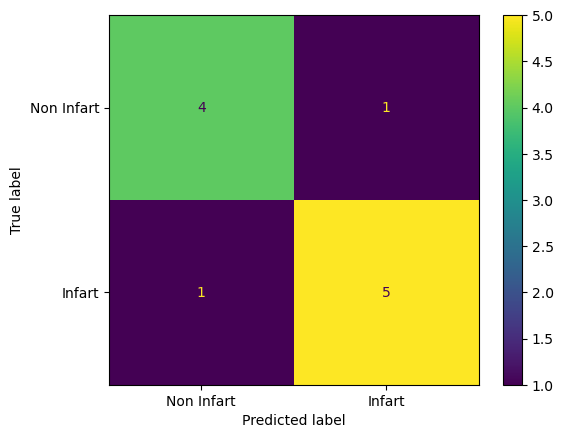

Fold 4
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




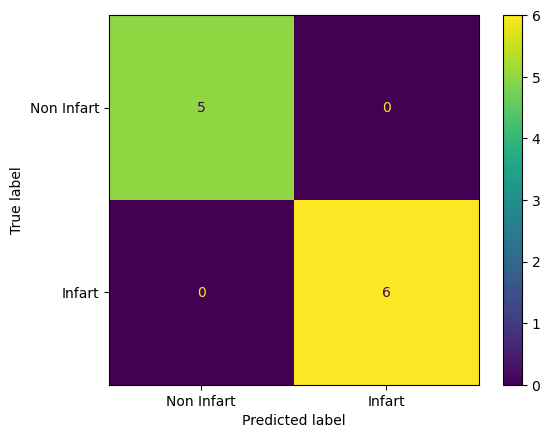

Mean Specificity= 0.9349999999999999 Std: 0.08306623862918074
Mean Sensibility= 0.9  Std: 0.13333333333333336


In [18]:
list_specificity = []
list_sensibility = []
estimators = scores['estimator']

for i, (train_index, test_index) in enumerate(cv.split(X_train)):
    
    X_pred = X_train[test_index]
    y_ground = y.iloc[test_index].values
    y_pred = estimators[0].predict(X_pred)
    tn, fp, fn, tp = confusion_matrix(y_ground, y_pred).ravel()
    sensibility = tp / (tp + fn)
    specificity = tn / (tn + fp)
    list_sensibility.append(sensibility)
    list_specificity.append(specificity)
    
    print(f"Fold {i}")
    print(f'Number of samples: {len(X_pred)}')
    print(f"Mean Specificity= {specificity}")
    print(f"Mean Sensibility= {sensibility}\n\n")
  
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_ground, y_pred), display_labels=['Non Infart', 'Infart']).plot()
    RocCurveDisplay.from_predictions(y_ground, y_pred, pos_label=1)
    plt.grid(False)
    plt.show()
    
print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}\n\n")

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




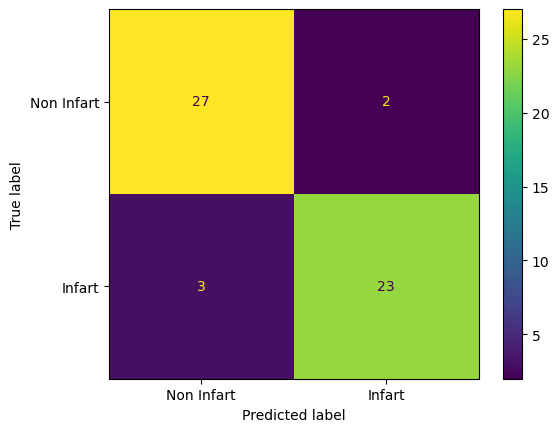

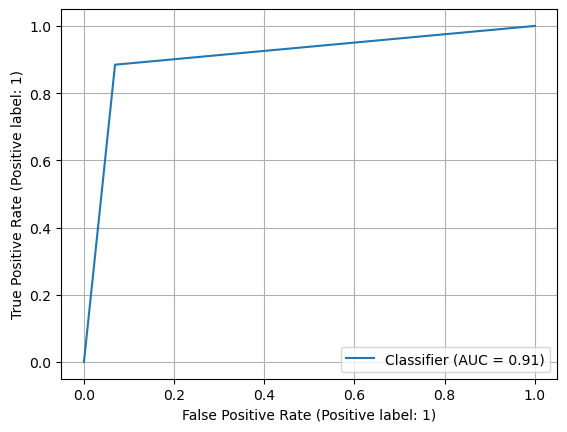

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




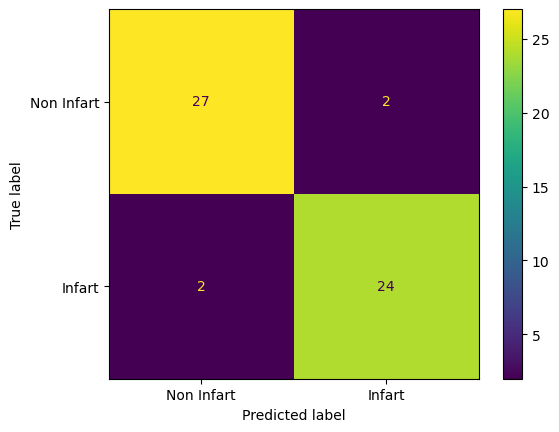

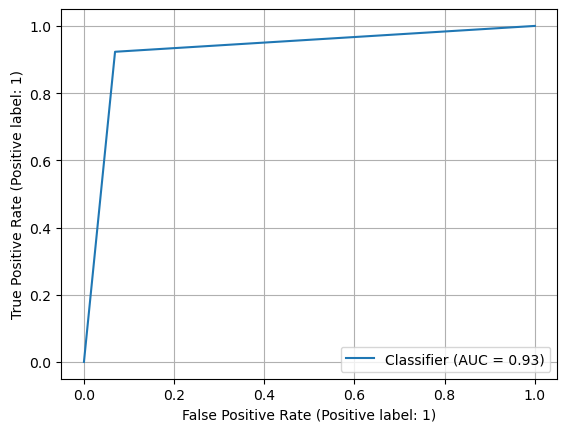

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




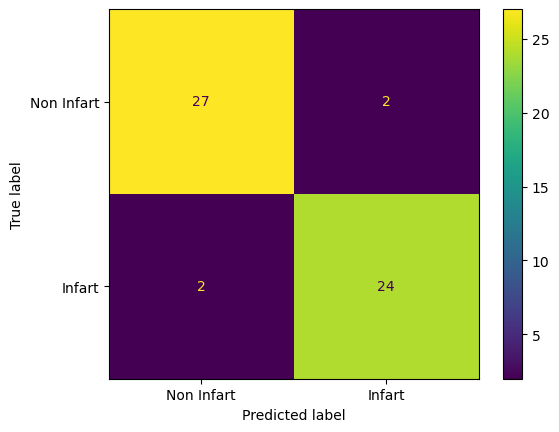

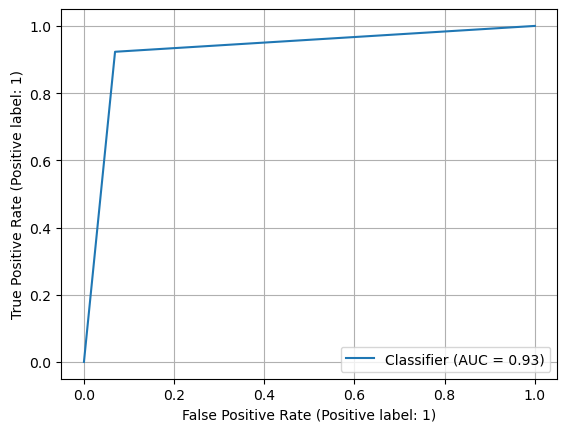

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




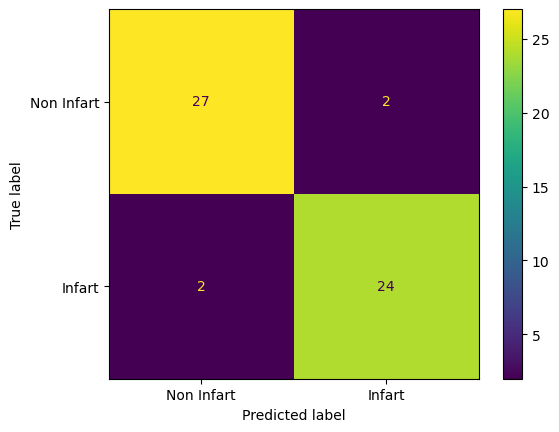

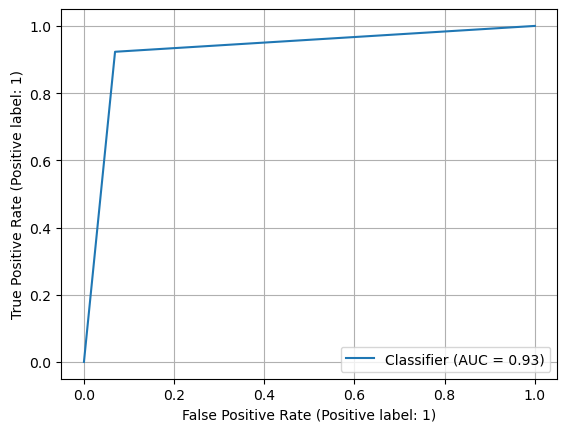

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




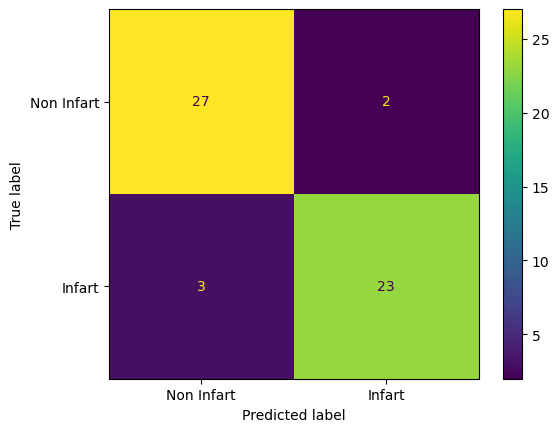

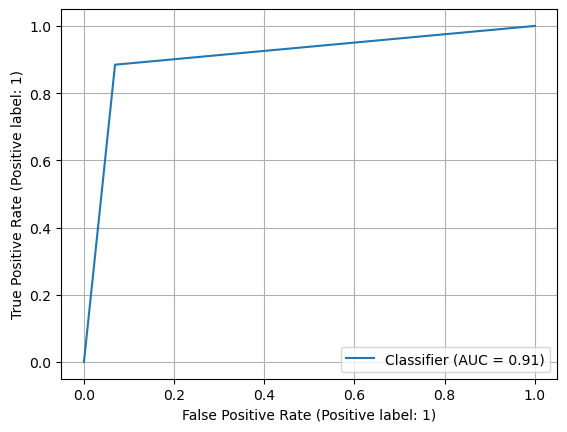

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




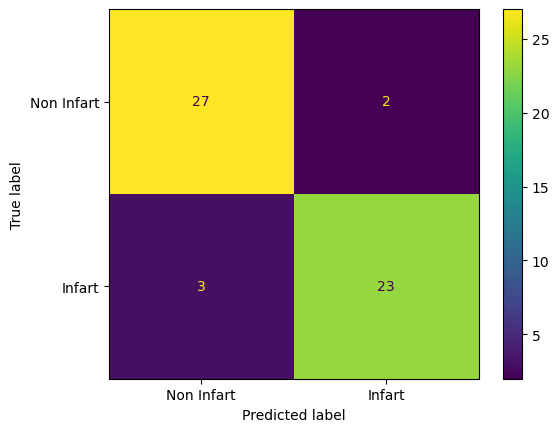

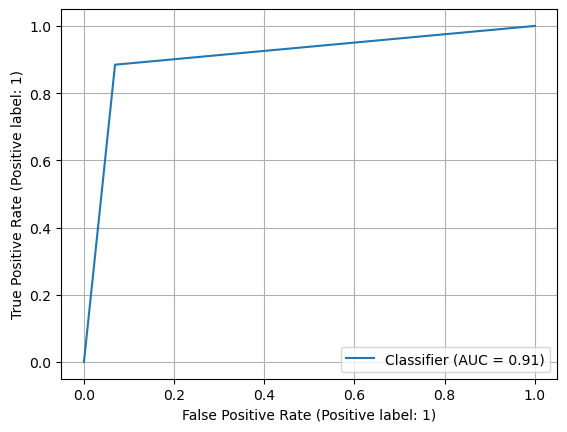

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




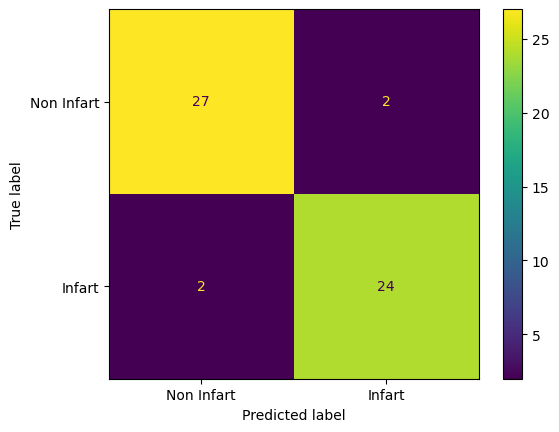

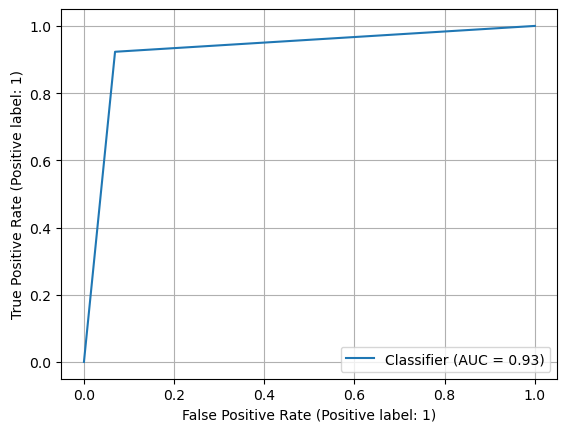

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




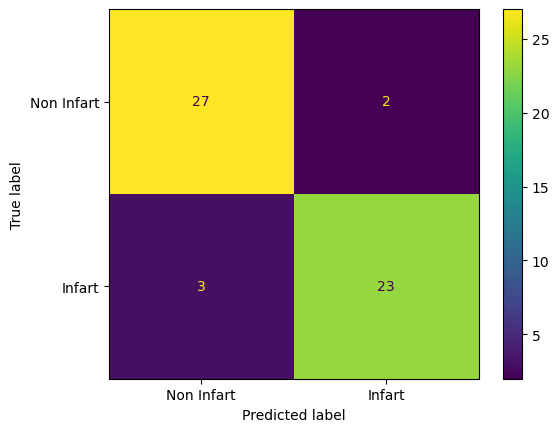

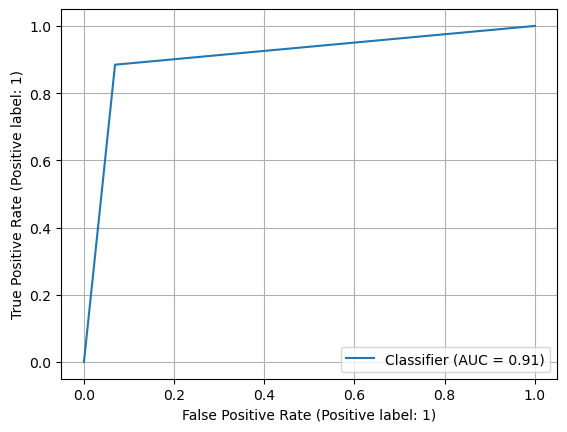

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




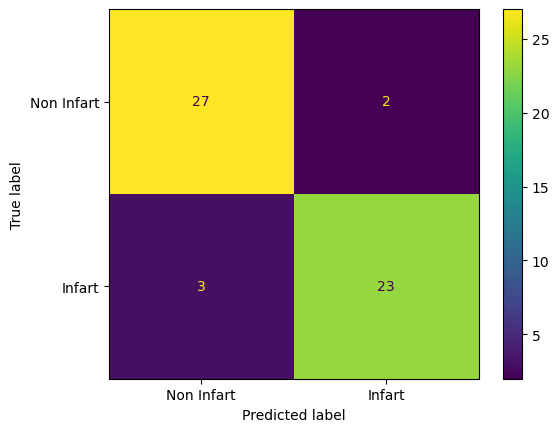

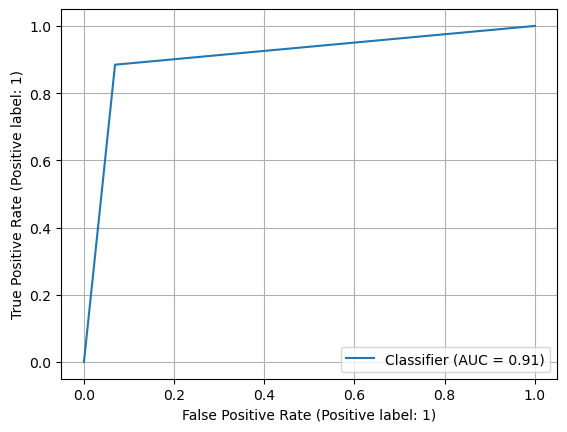

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




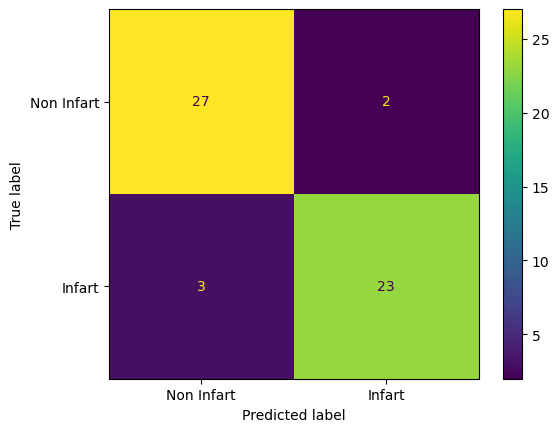

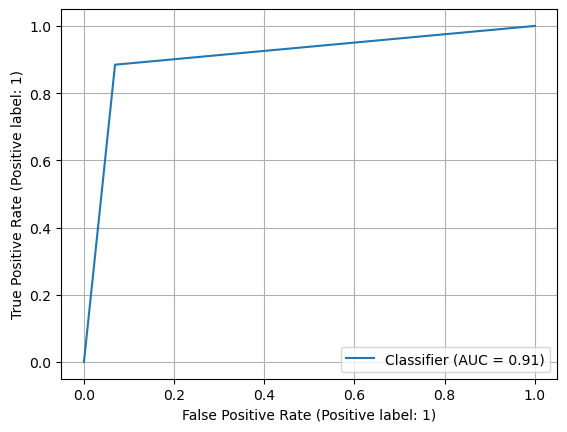

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




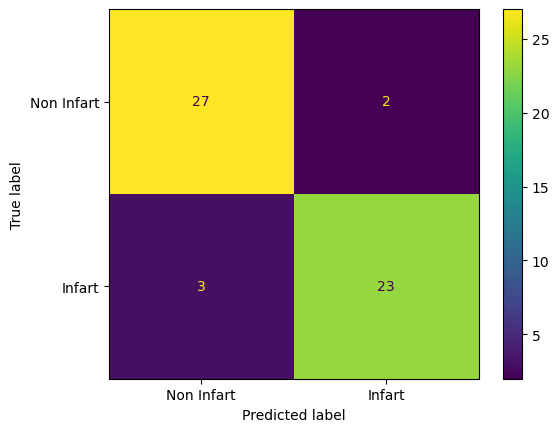

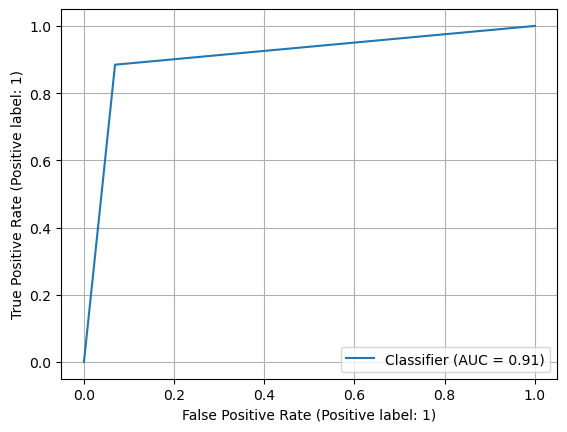

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




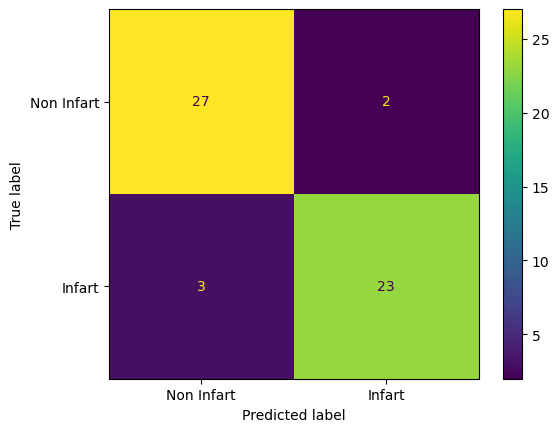

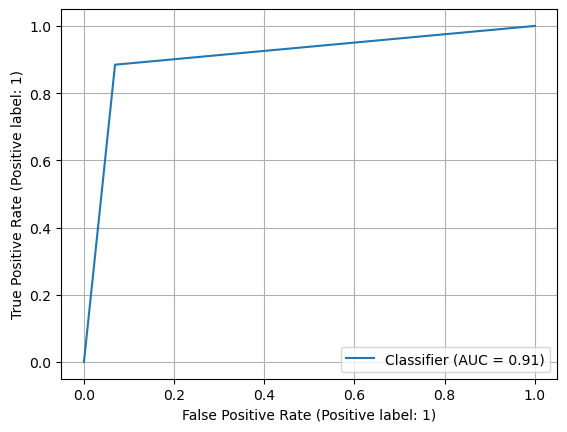

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




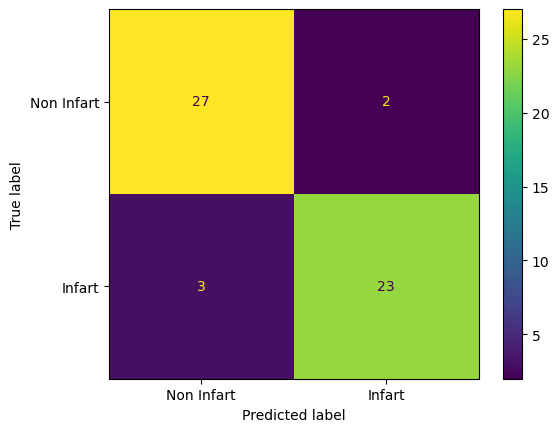

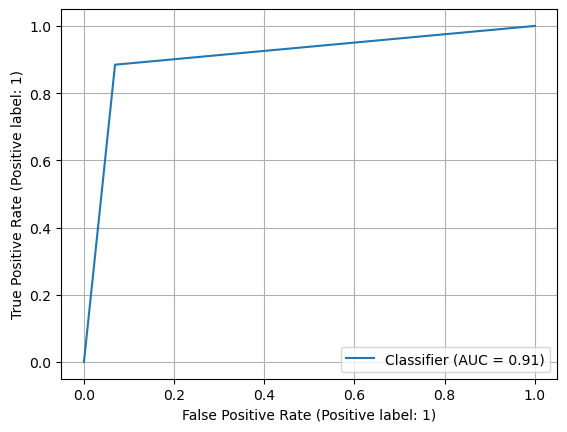

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




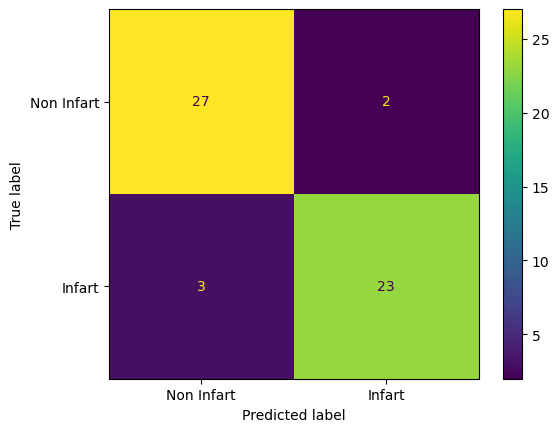

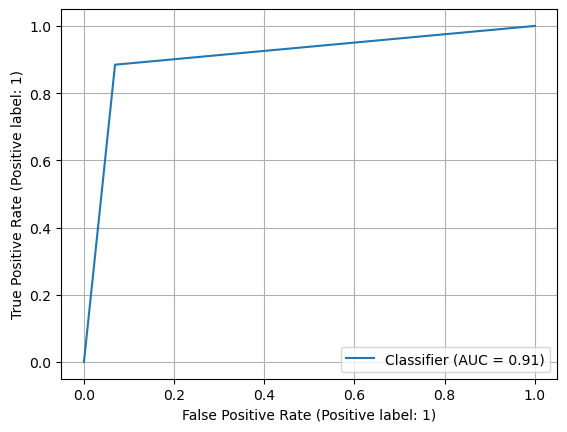

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




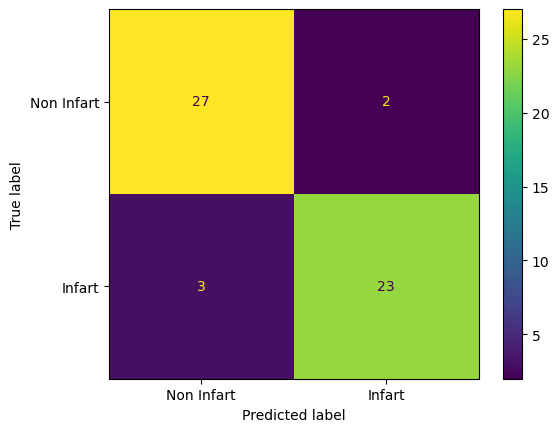

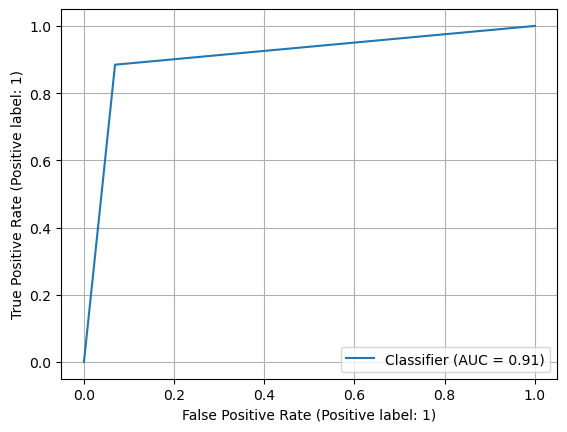

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




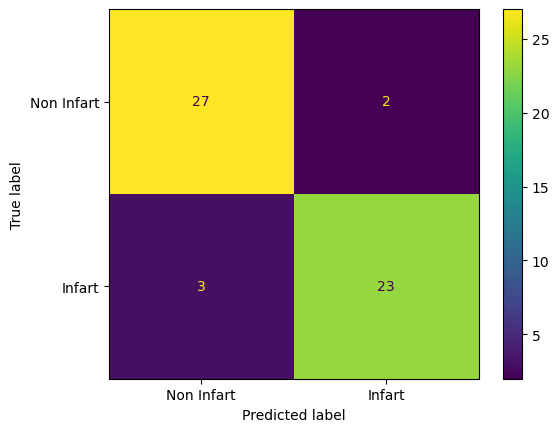

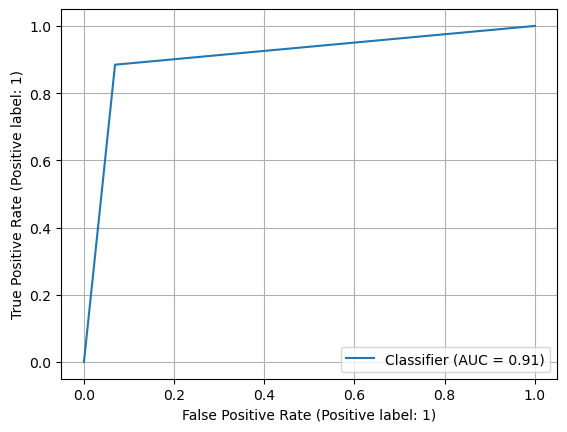

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




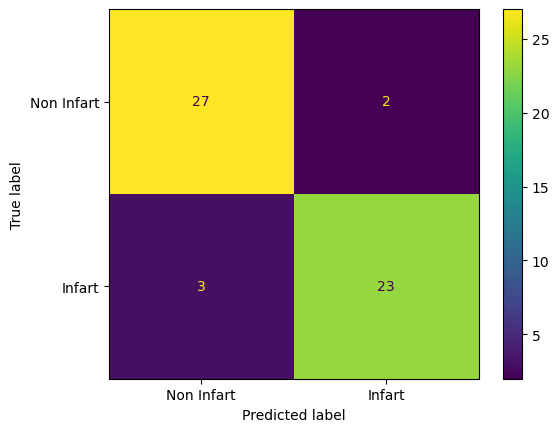

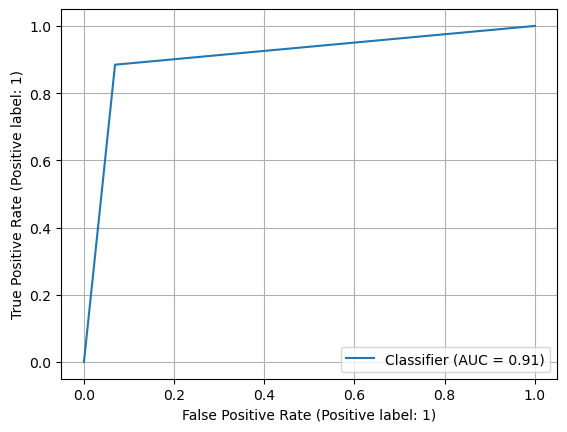

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




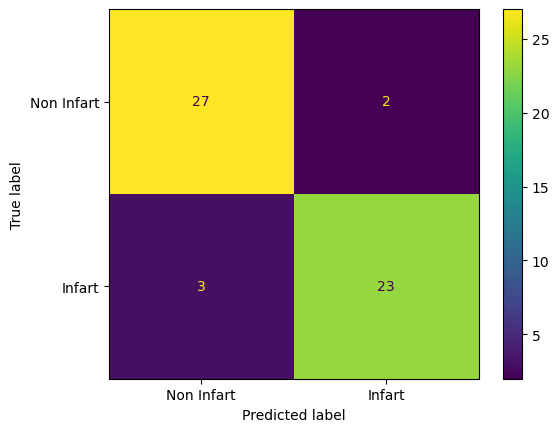

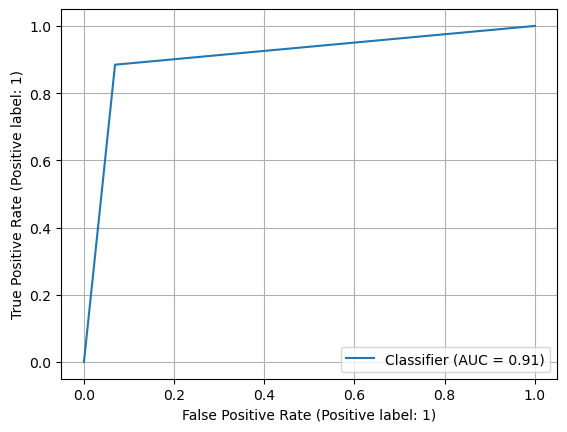

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




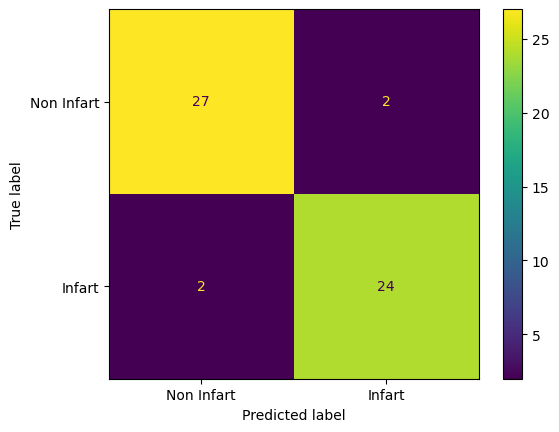

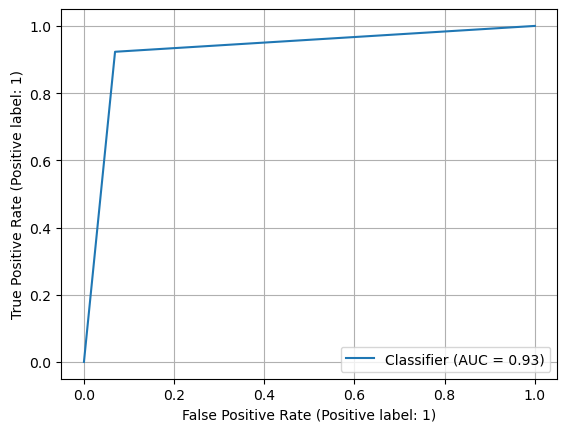

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




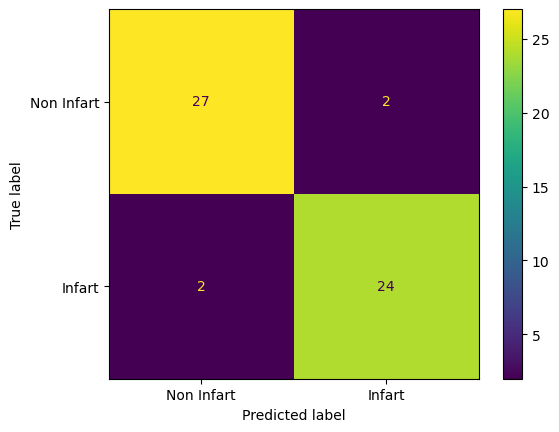

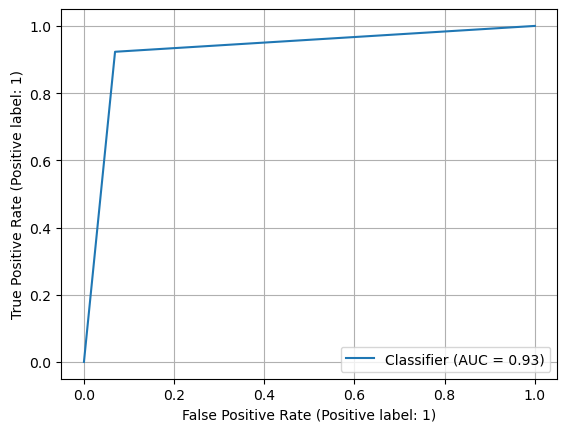

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




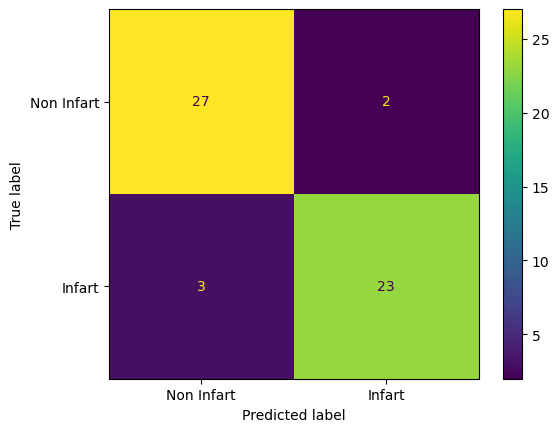

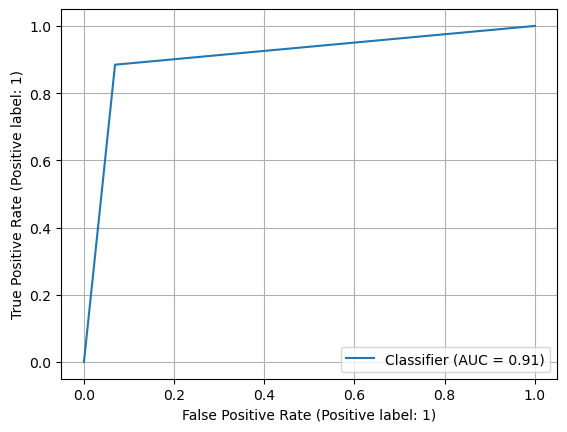

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




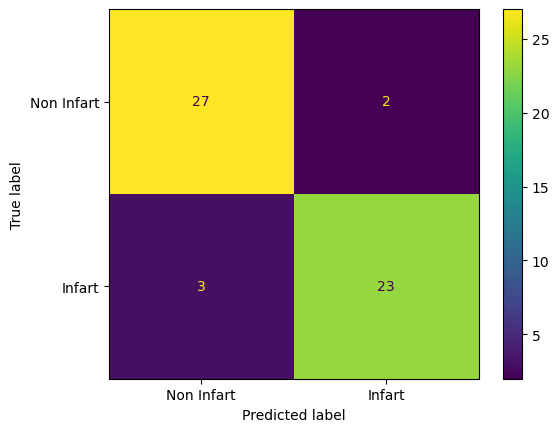

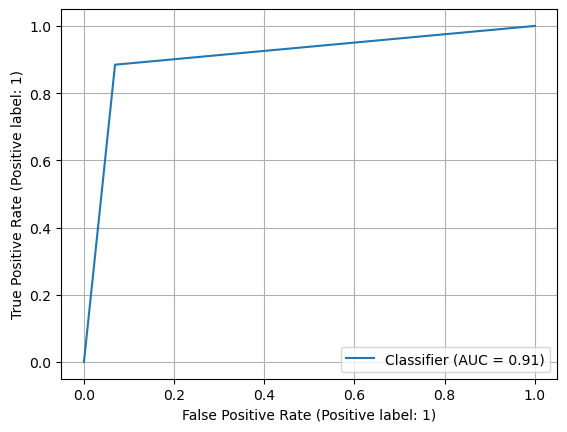

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




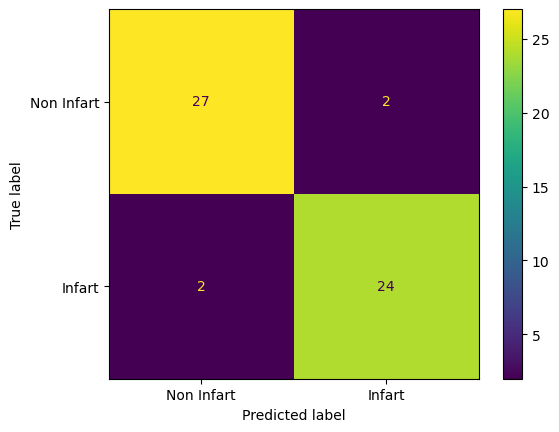

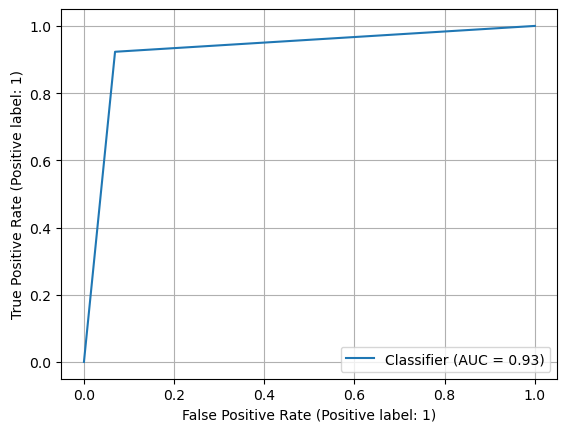

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077




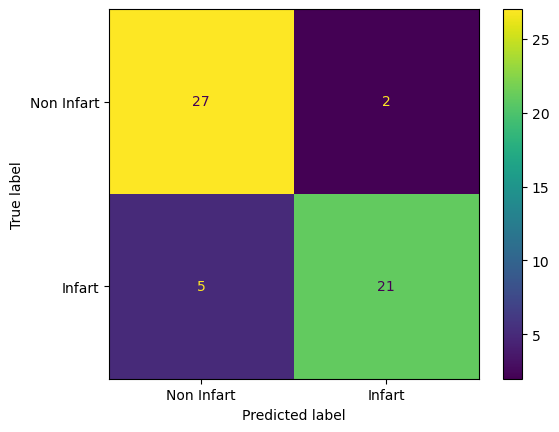

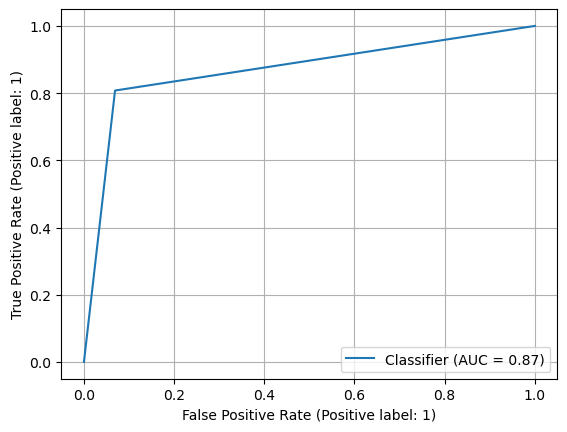

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




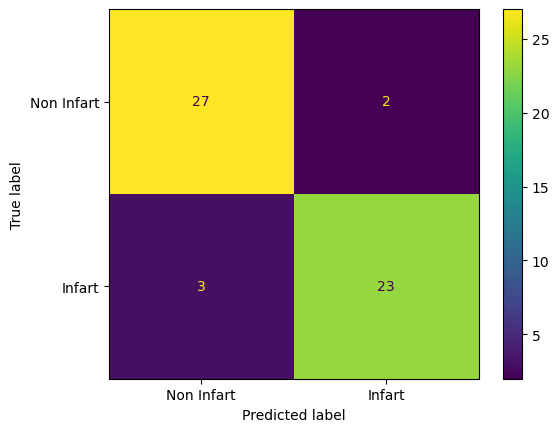

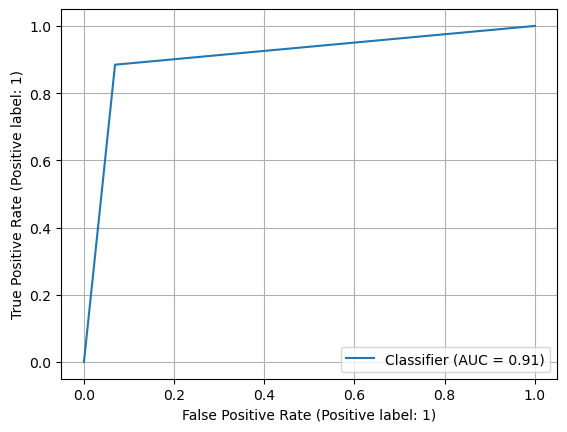

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




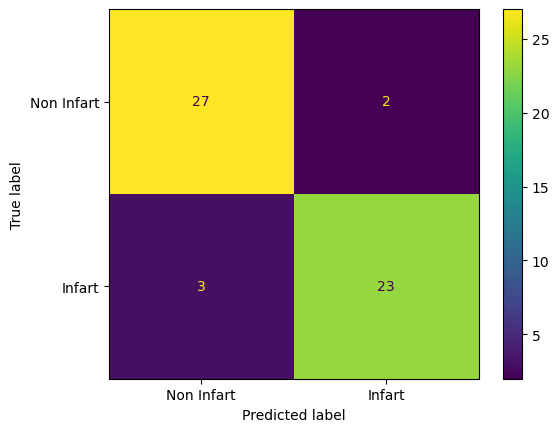

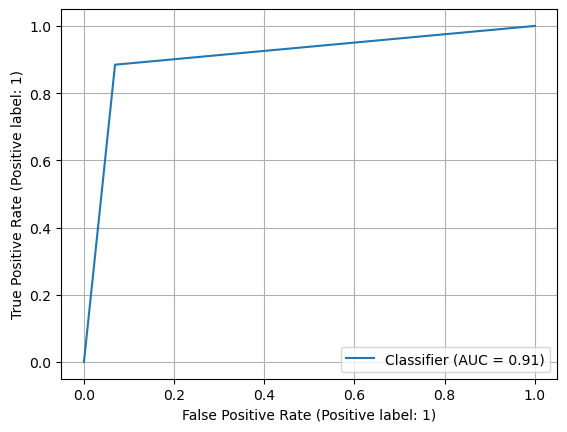

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




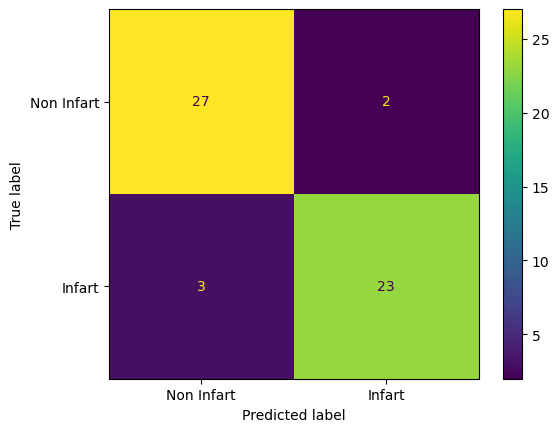

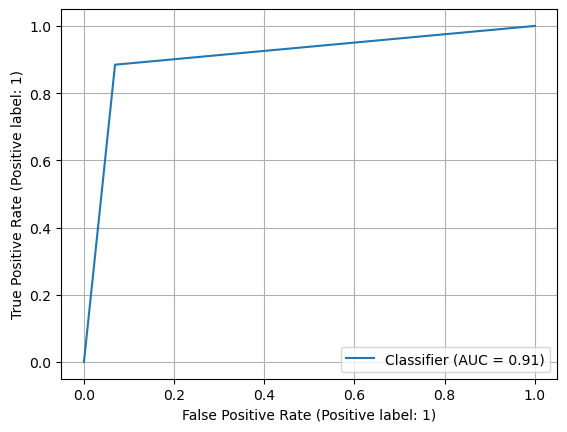

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




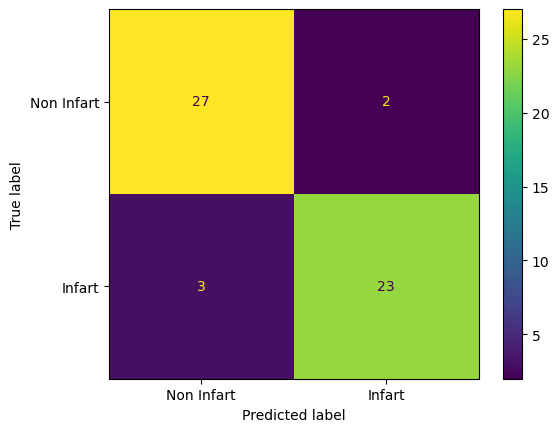

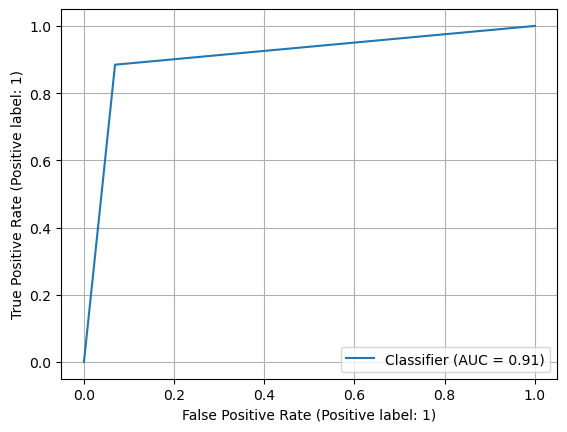

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




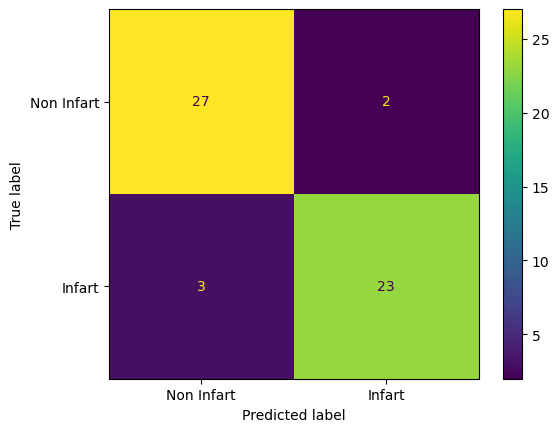

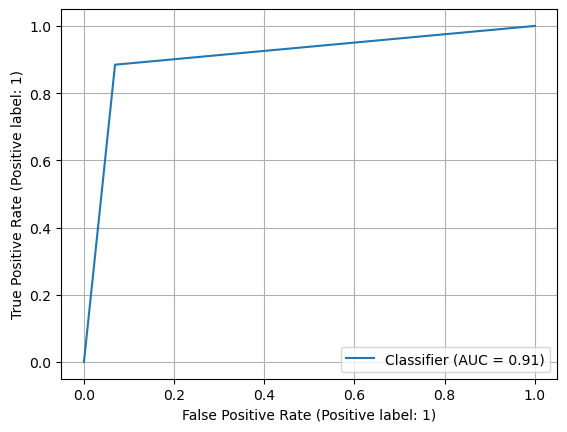

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




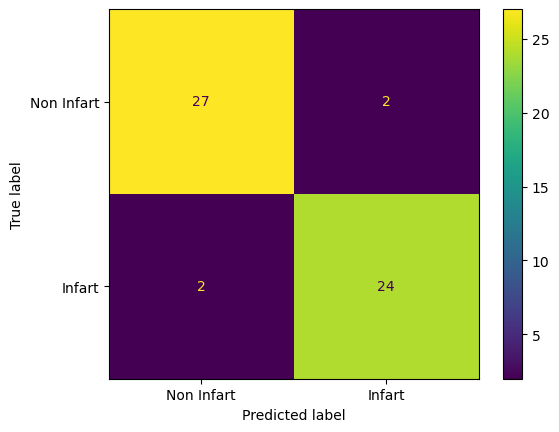

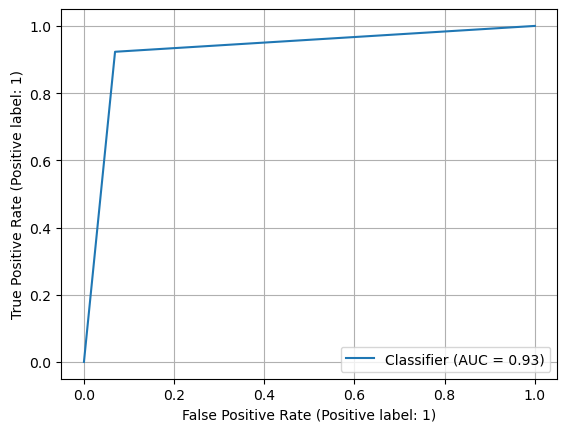

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




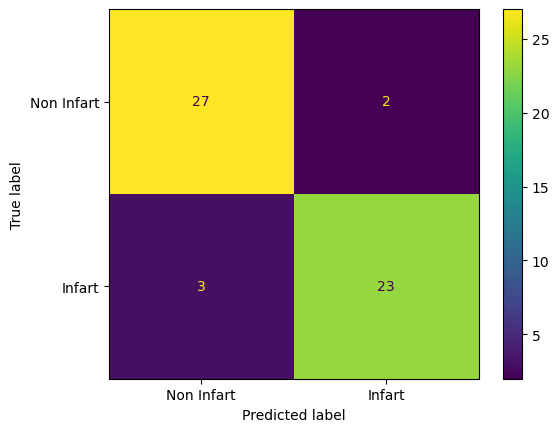

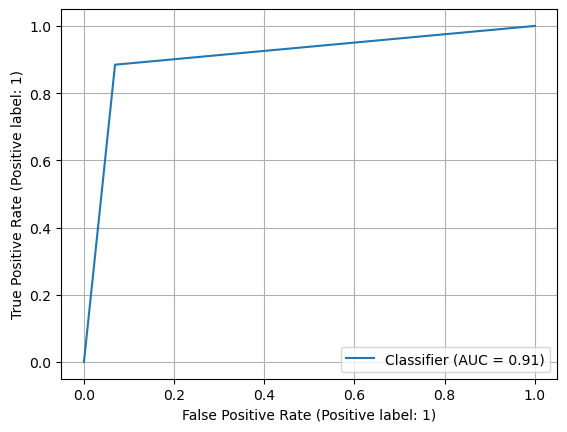

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




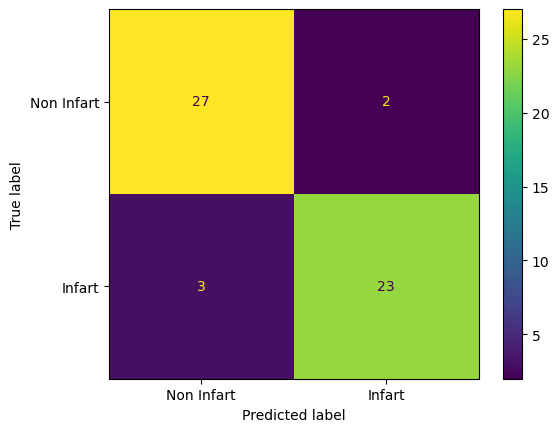

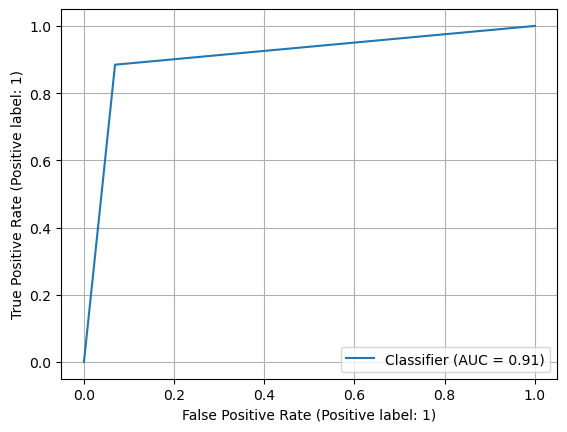

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




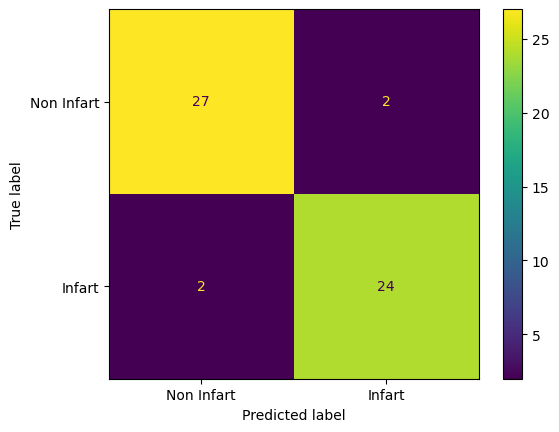

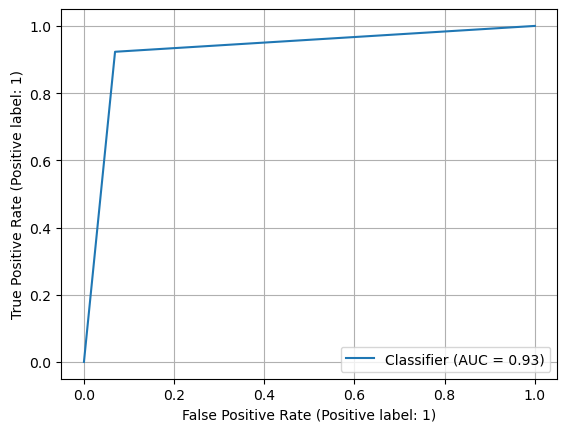

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




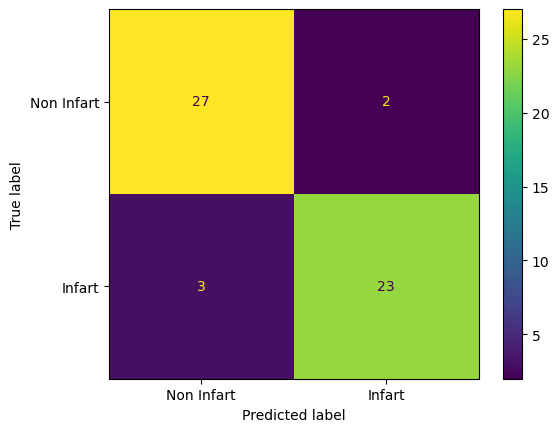

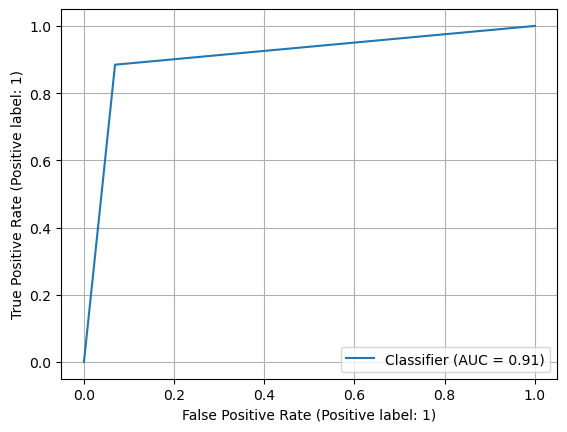

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8461538461538461




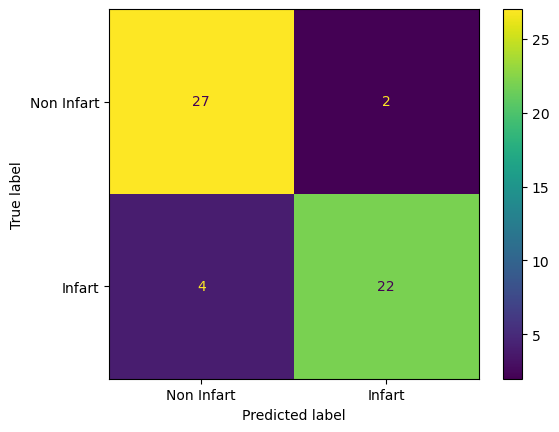

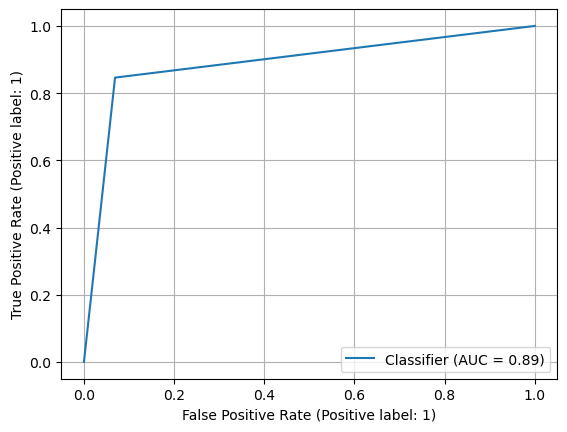

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




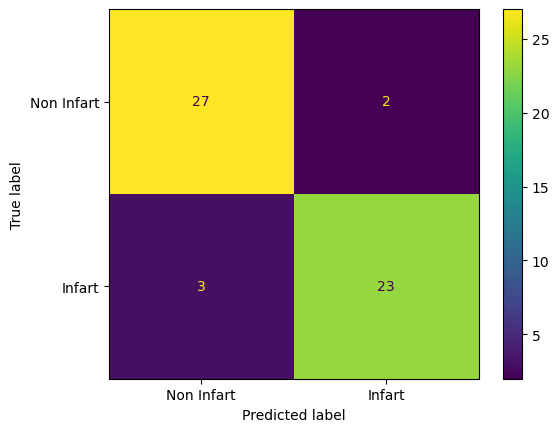

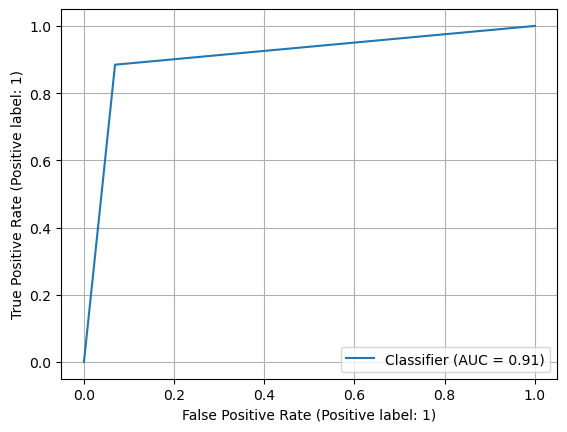

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




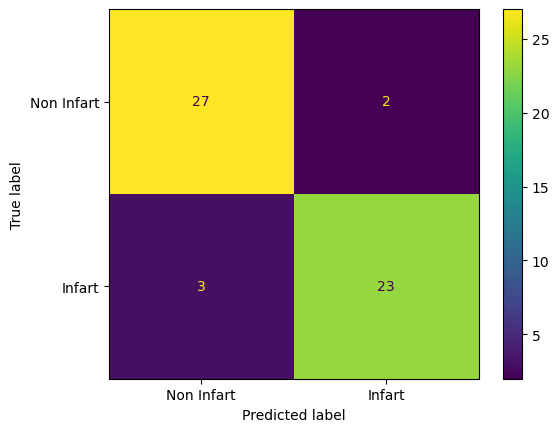

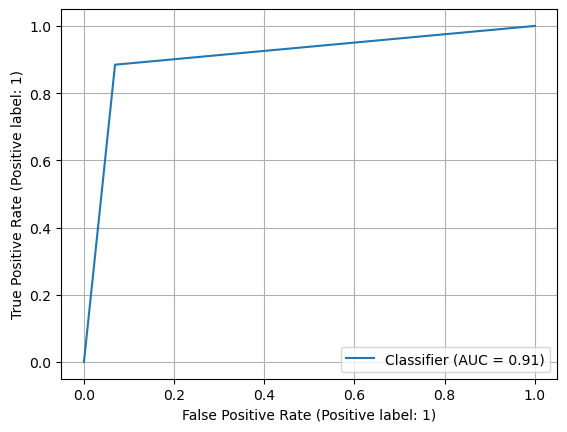

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




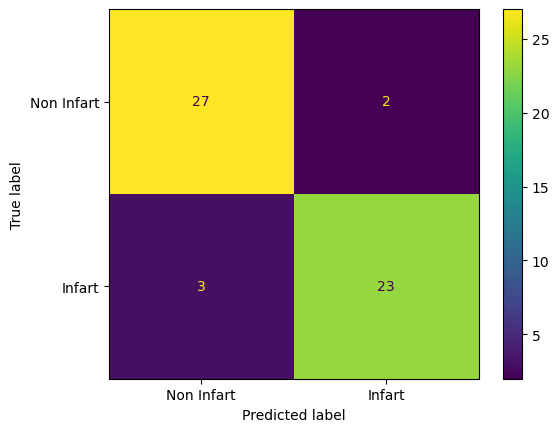

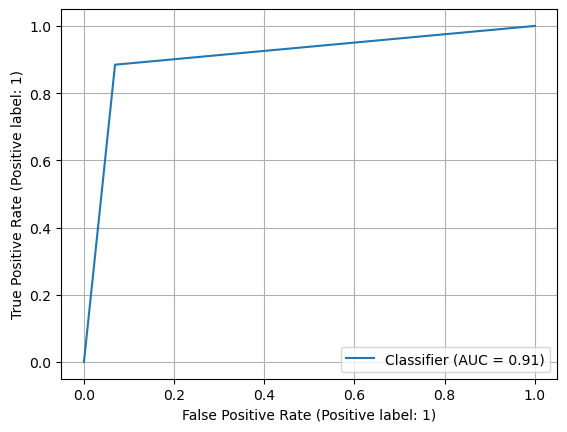

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




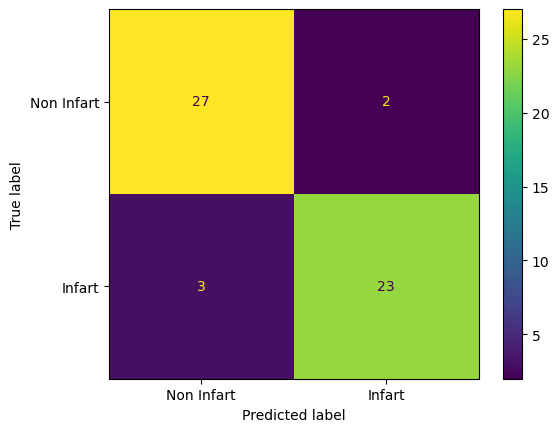

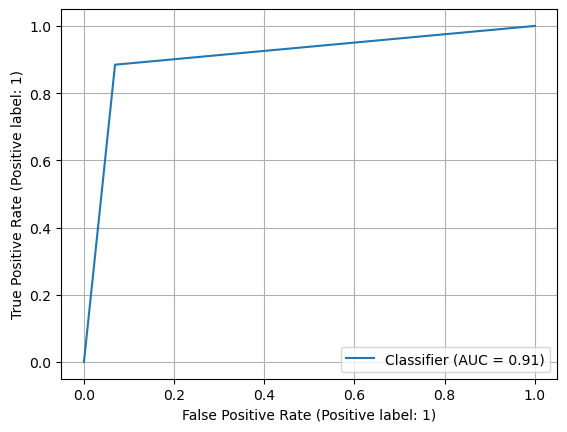

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




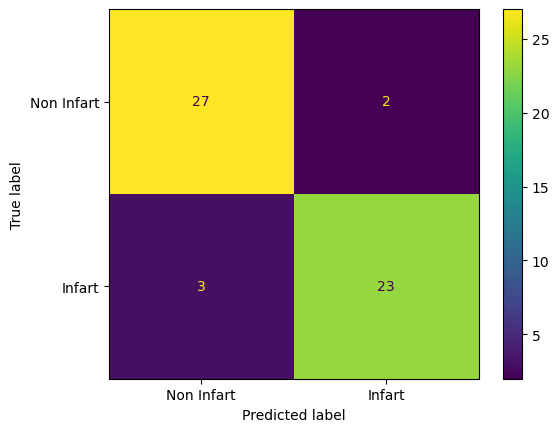

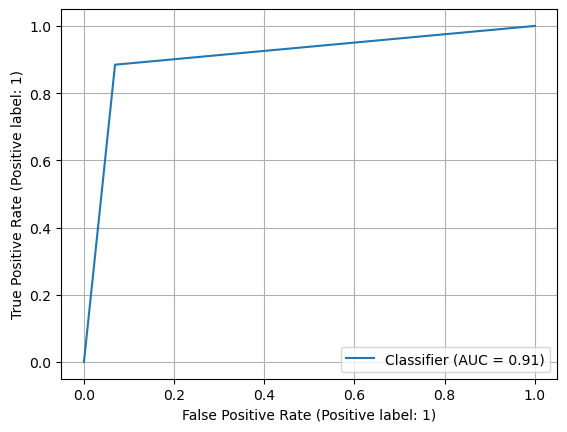

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




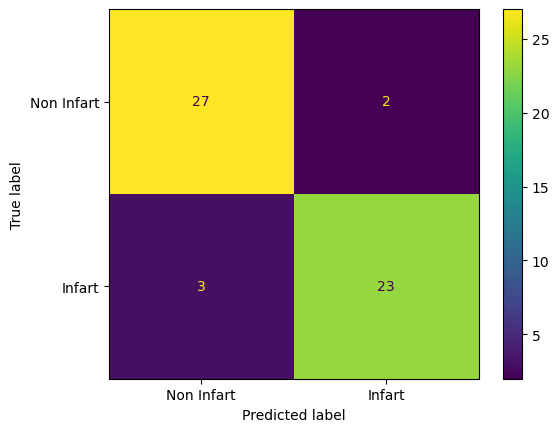

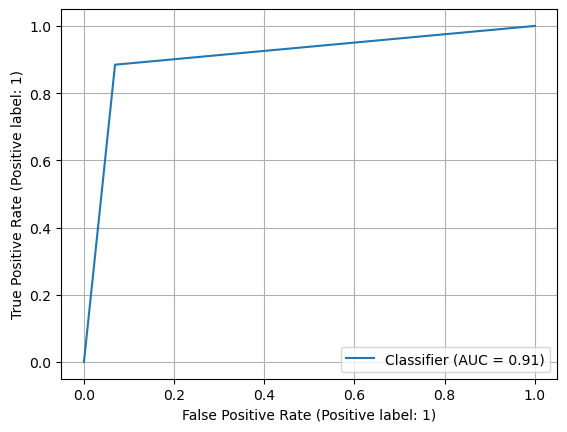

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




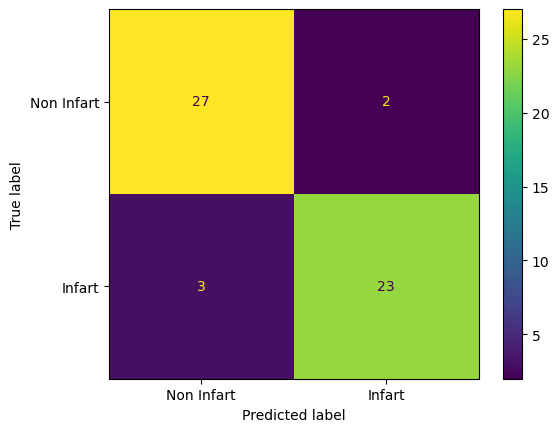

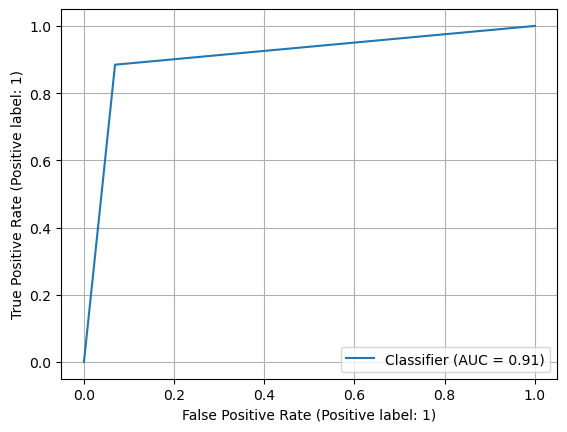

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




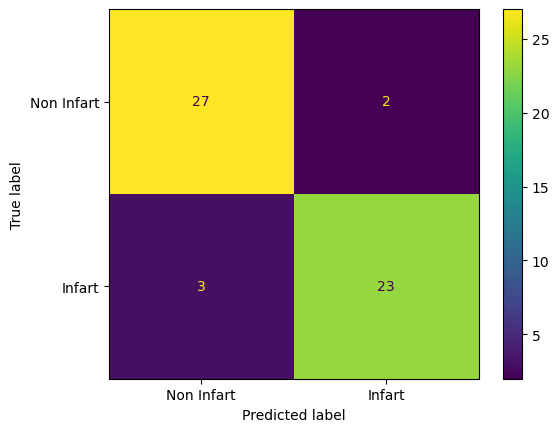

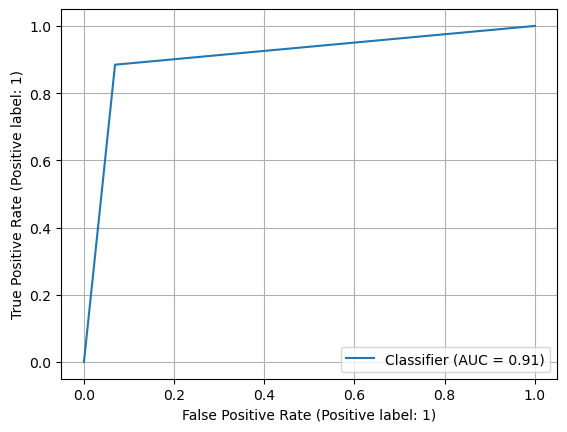

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




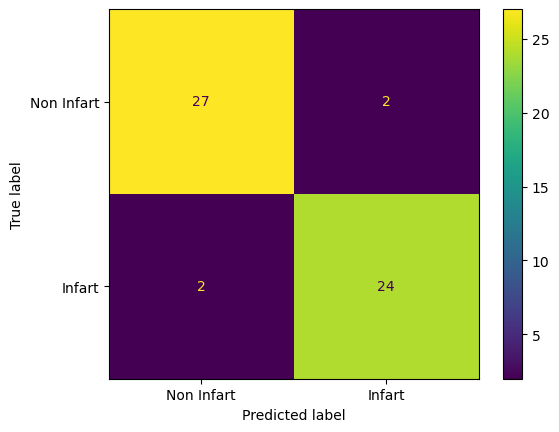

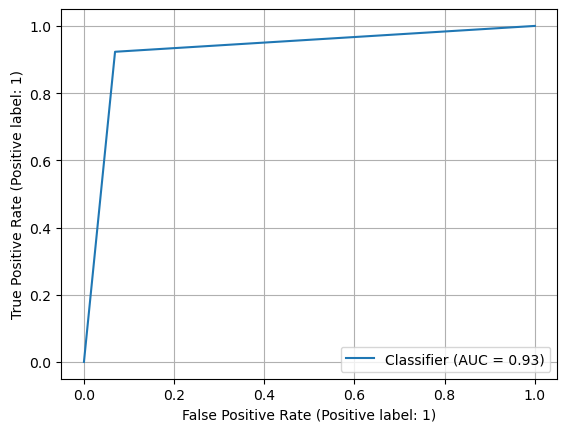

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




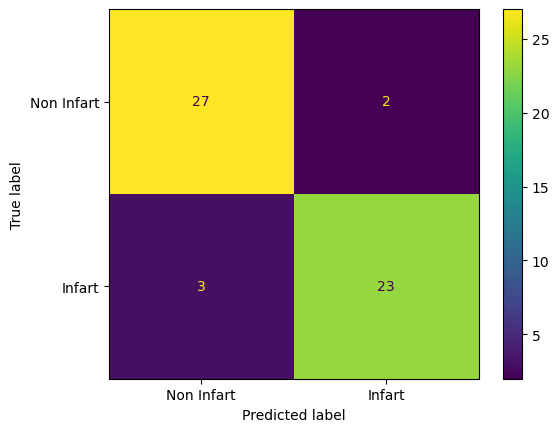

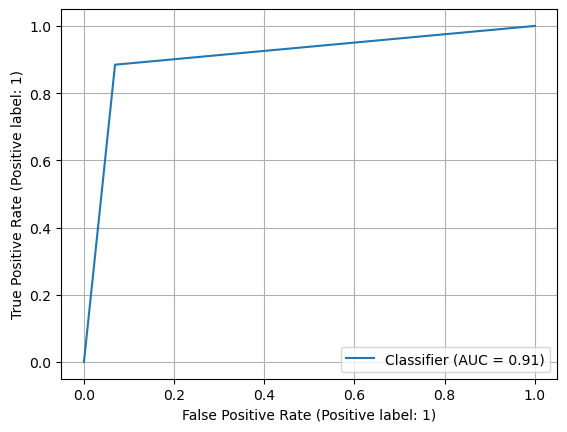

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




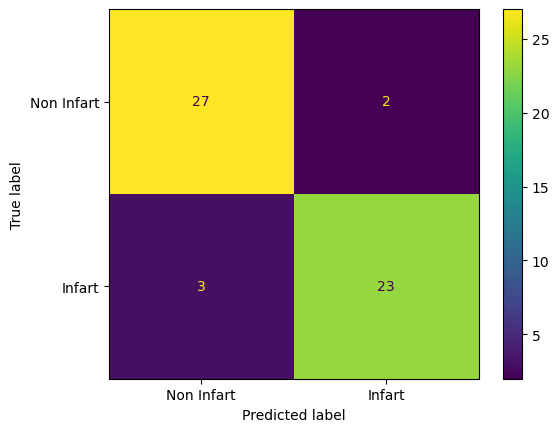

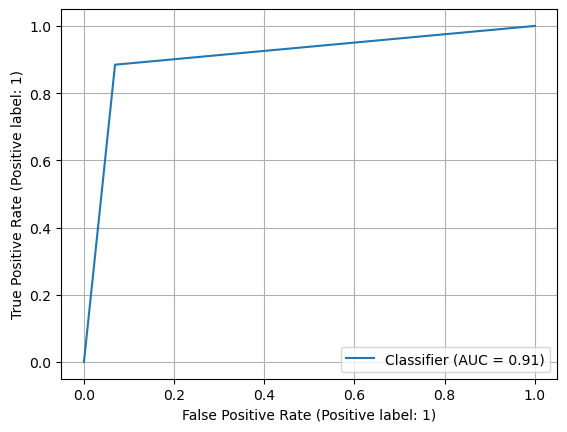

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




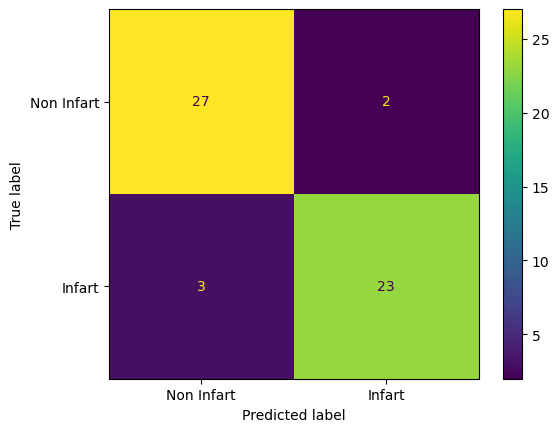

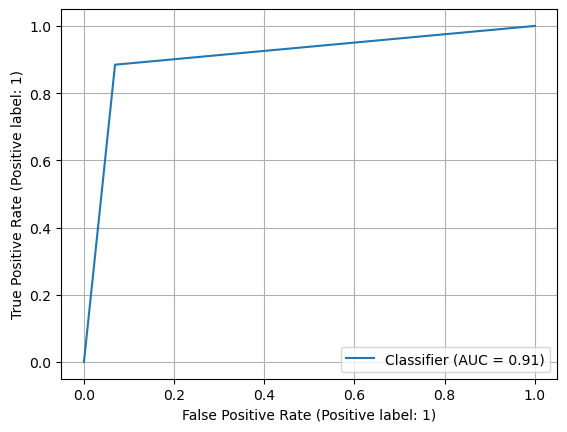

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




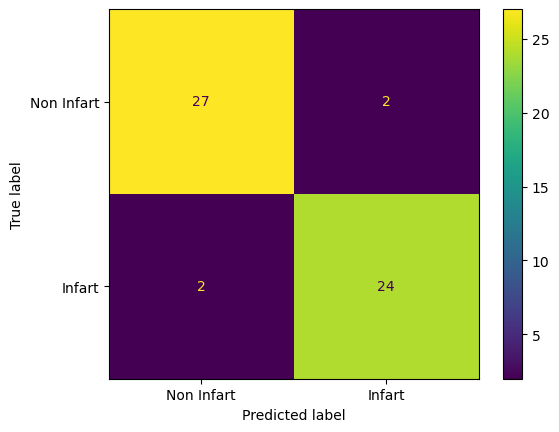

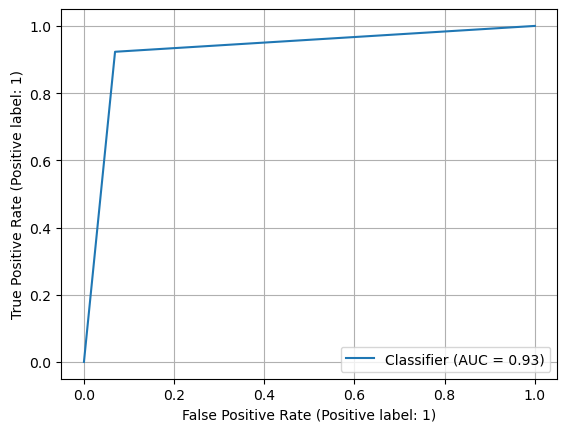

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




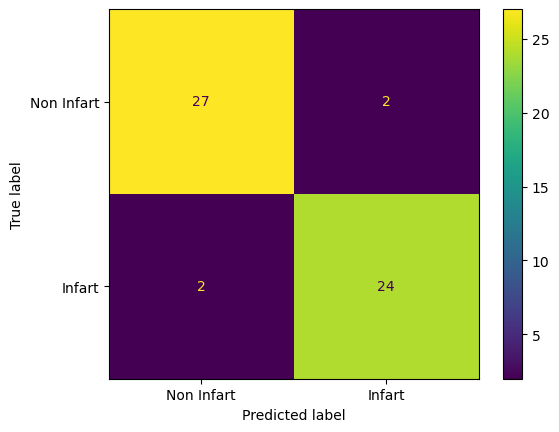

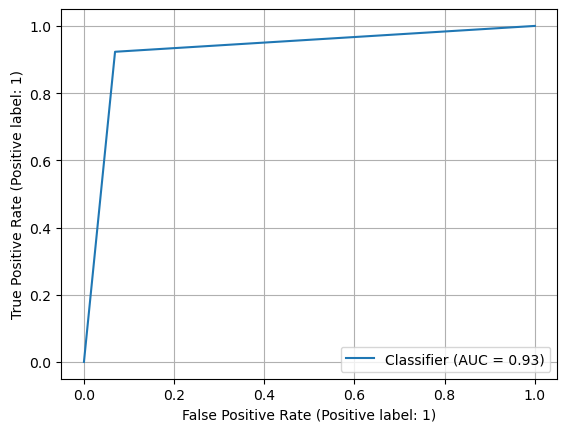

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




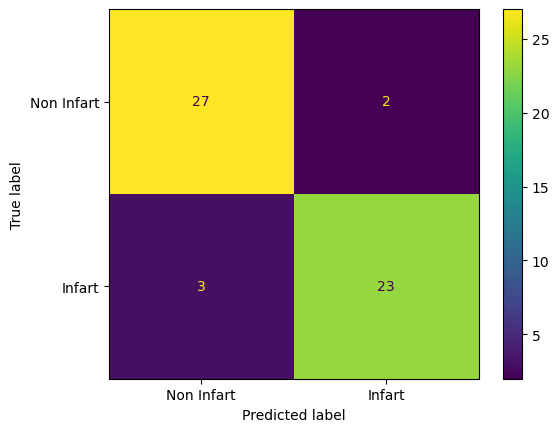

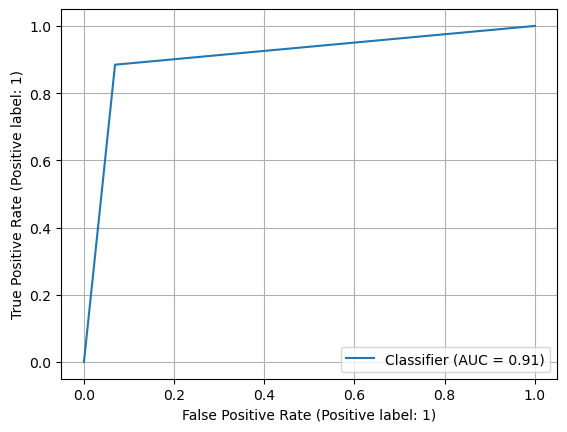

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




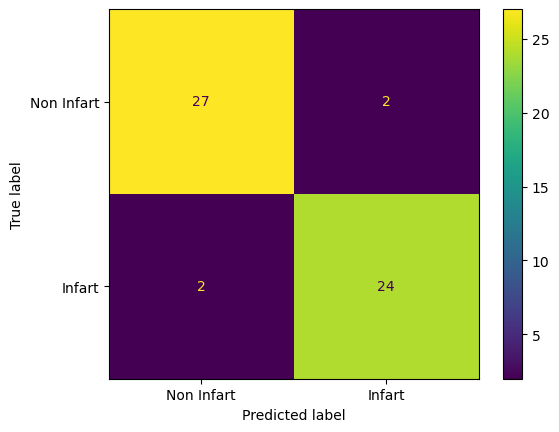

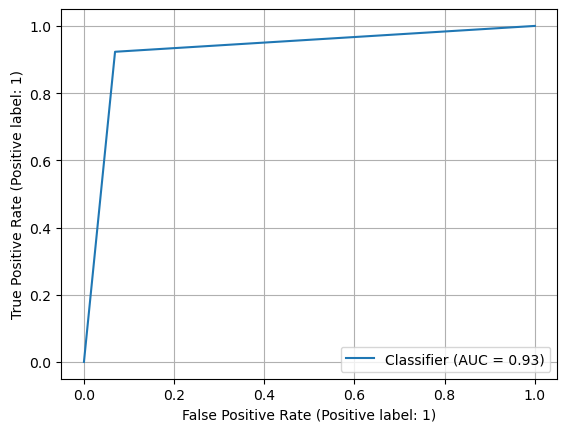

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




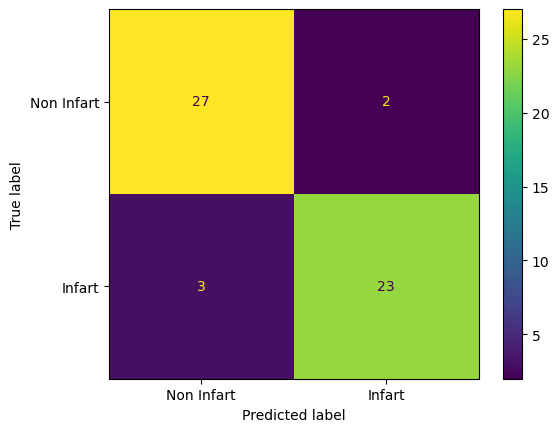

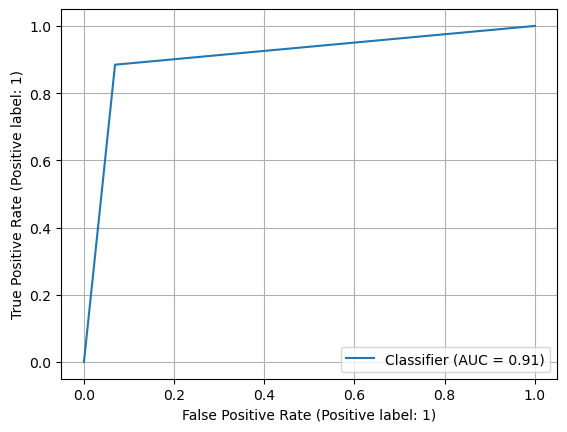

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




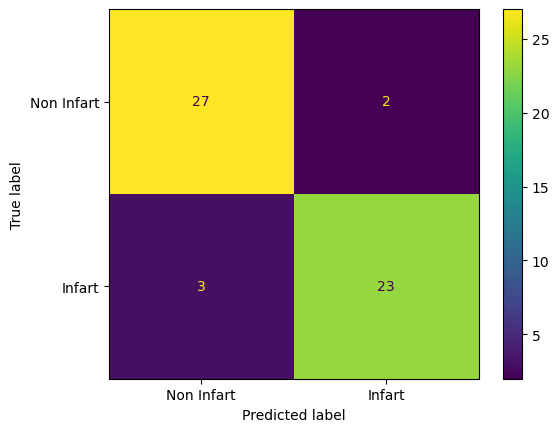

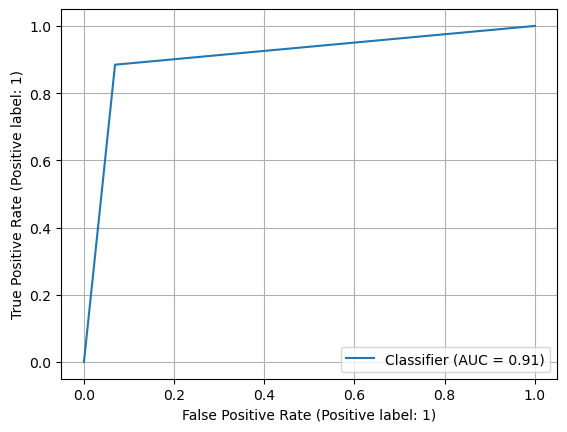

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.9230769230769231




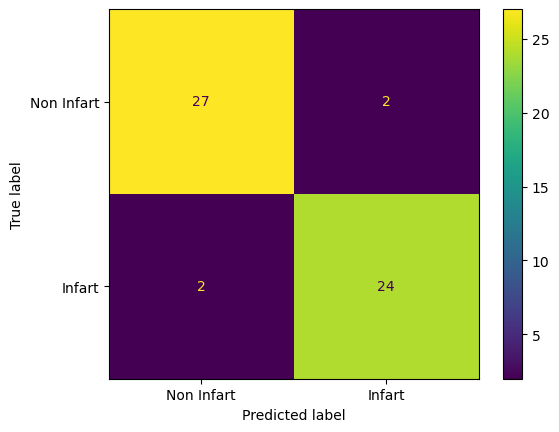

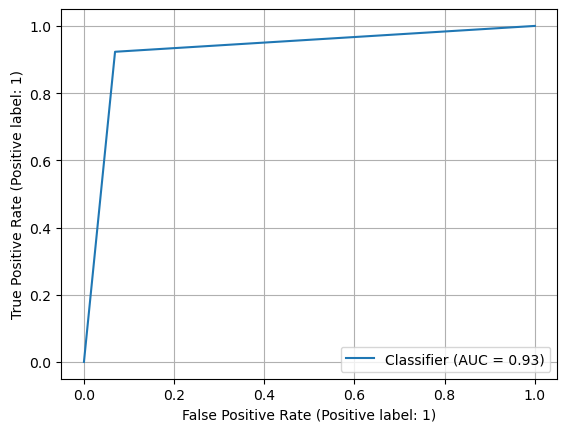

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8846153846153846




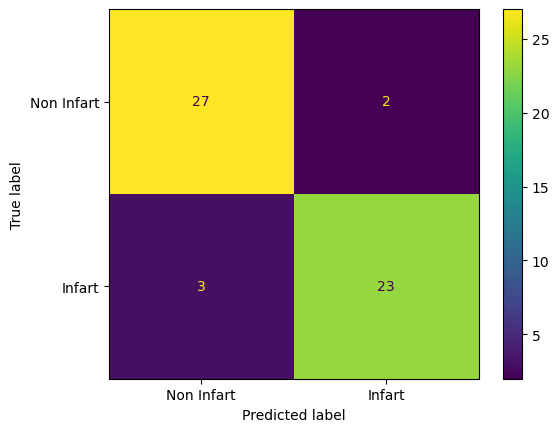

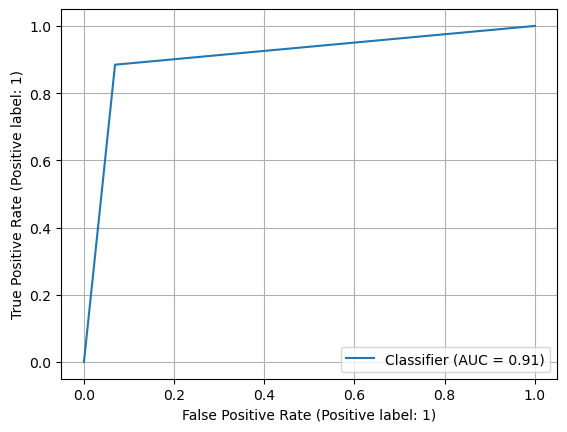

Mean Specificity= 0.9310344827586206 Std: 1.1102230246251565e-16
Mean Sensibility= 0.8923076923076924  Std: 0.021256900914084872


In [32]:
# Verificando a media com todos os elementos e classificadores
list_specificity = []
list_sensibility = []
estimators = scores['estimator']

for i, estimator in enumerate(estimators):
    X_pred = X_train
    y_truth = y.values
    y_pred = estimator.predict(X_pred)
    tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
    sensibility = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Number of samples: {len(X_pred)}')
    print(f"Specificity= {specificity}")
    print(f"Sensibility= {sensibility}\n\n")
    list_sensibility.append(sensibility)
    list_specificity.append(specificity)
    
    ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_truth, y_pred), display_labels=['Non Infart', 'Infart']).plot()
    RocCurveDisplay.from_predictions(y_truth, y_pred, pos_label=1)
    plt.grid(True)
    plt.show()

print(f"Mean Specificity= {np.mean(list_specificity)} Std: {np.std(list_specificity)}")
print(f"Mean Sensibility= {np.mean(list_sensibility)}  Std: {np.std(list_sensibility)}")

# KNN

Accuracy: 0.8


Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077
False positive rate = 0.06896551724137934




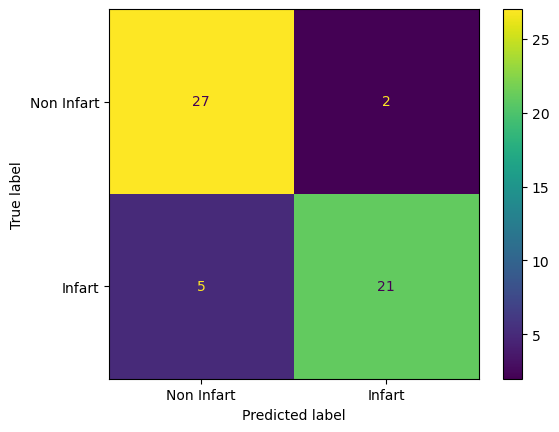

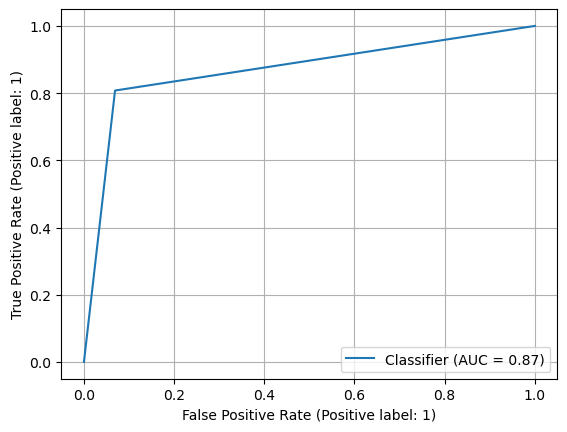

Number of samples: 55
Specificity= 0.896551724137931
Sensibility= 0.8076923076923077
False positive rate = 0.10344827586206895




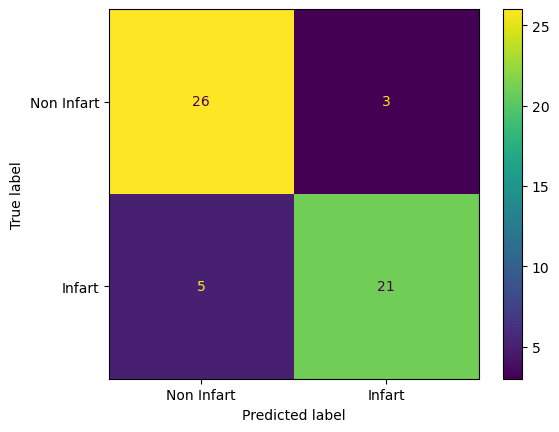

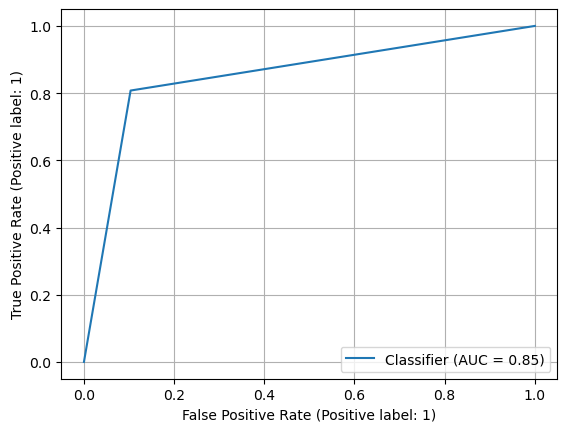

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077
False positive rate = 0.06896551724137934




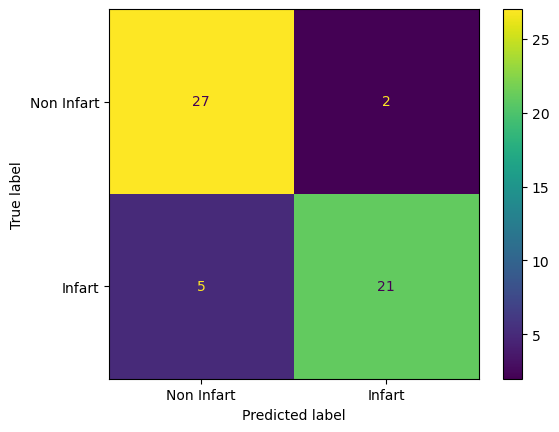

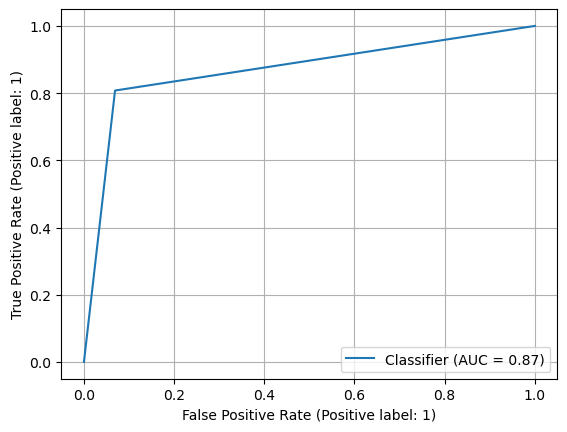

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




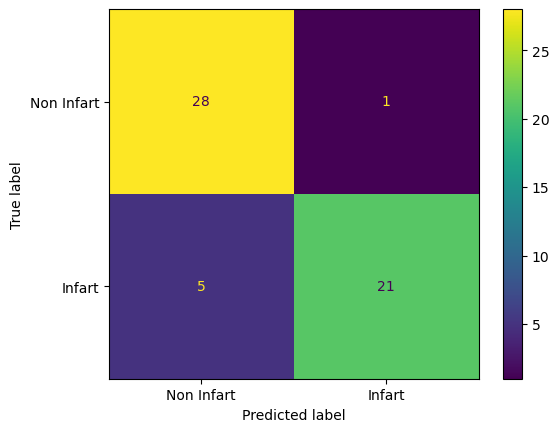

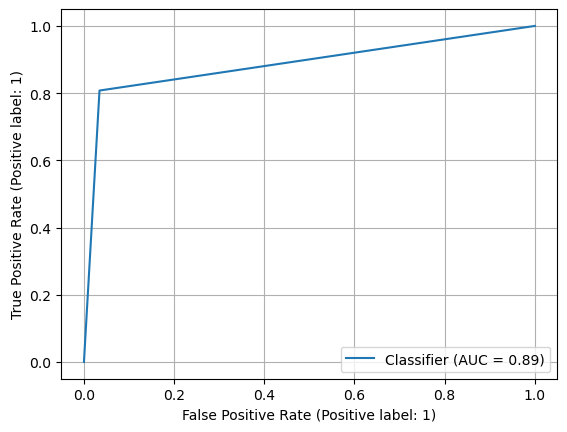

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




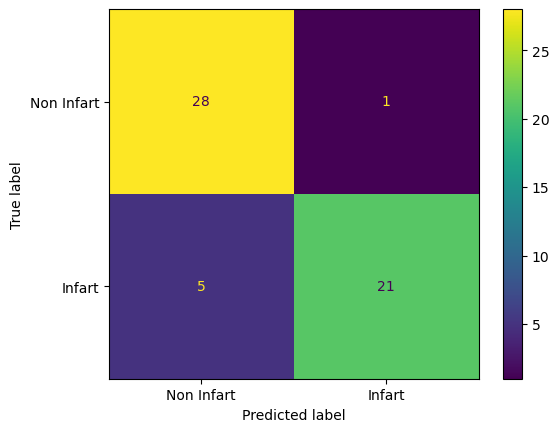

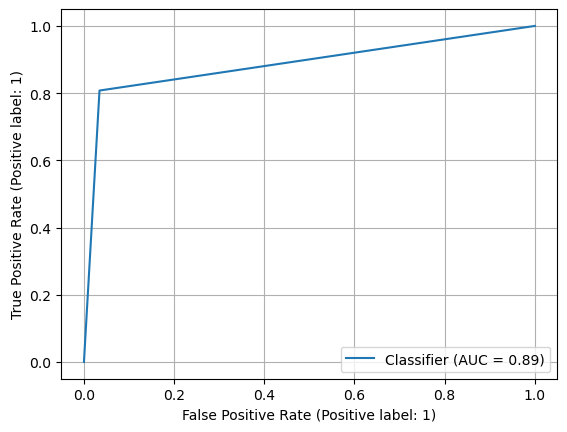

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




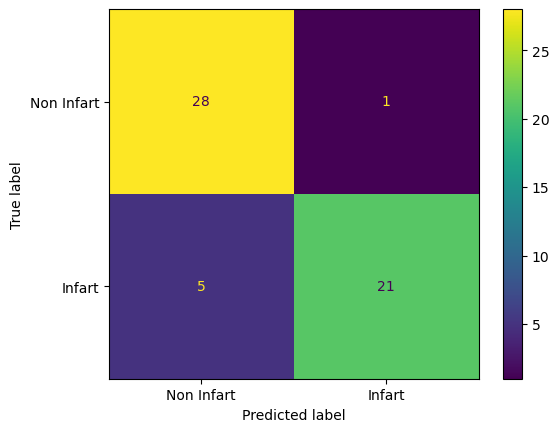

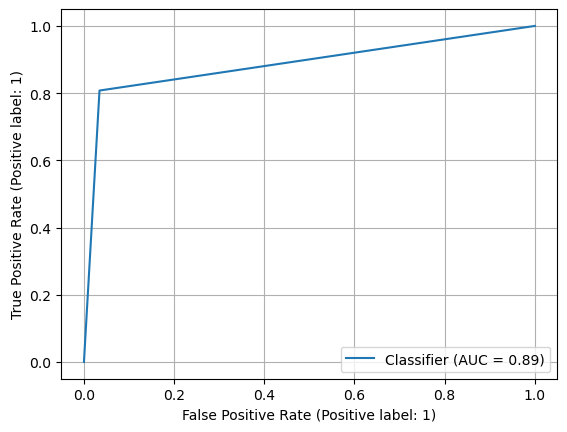

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




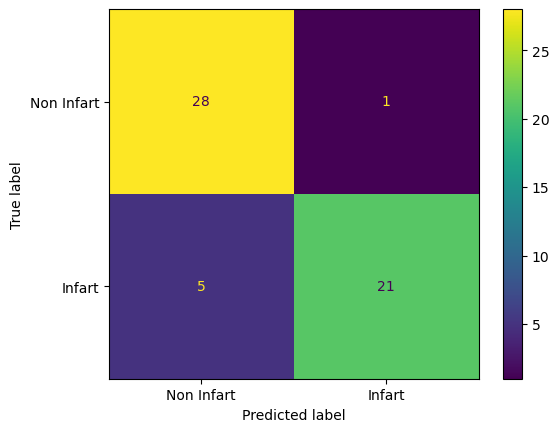

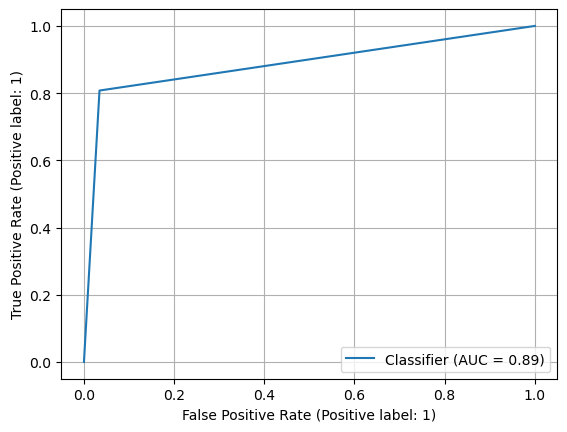

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




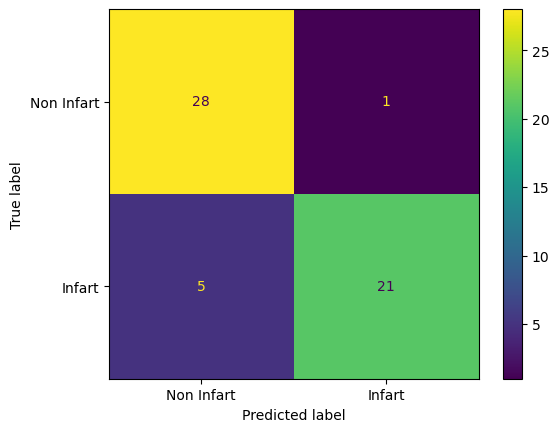

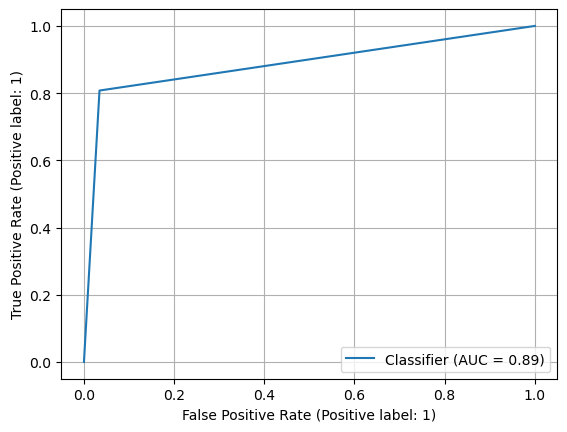

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




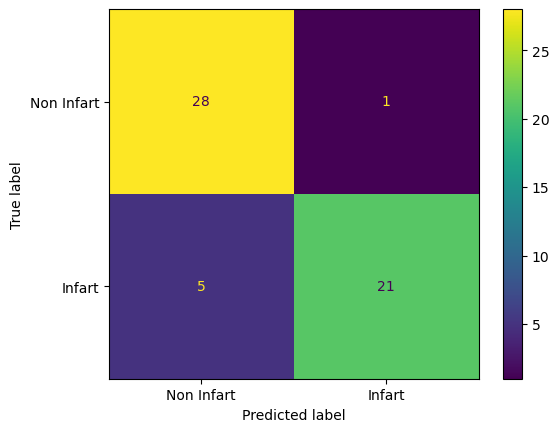

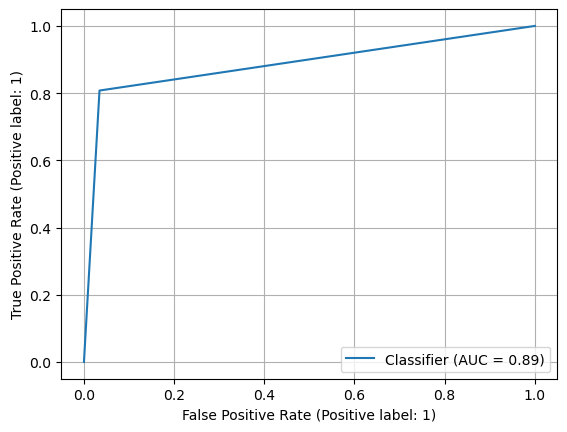

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




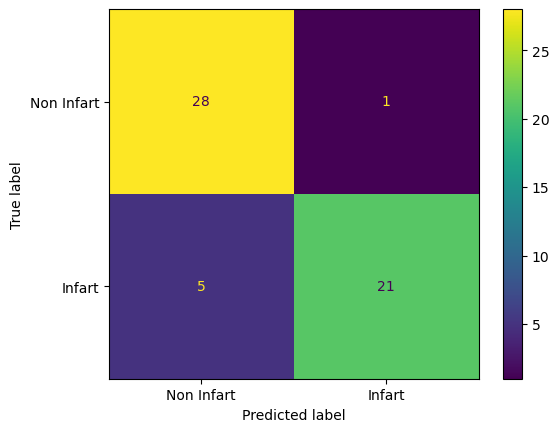

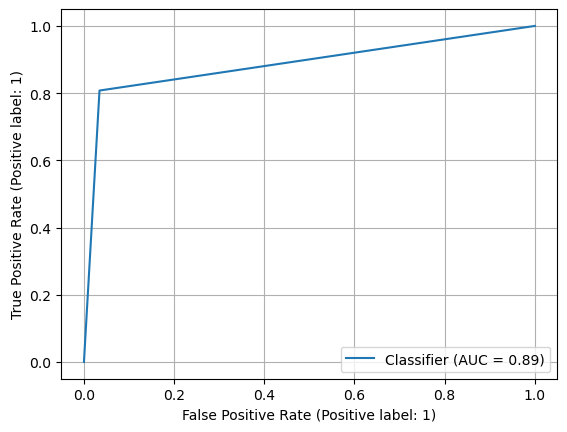

Number of samples: 55
Specificity= 0.896551724137931
Sensibility= 0.8076923076923077
False positive rate = 0.10344827586206895




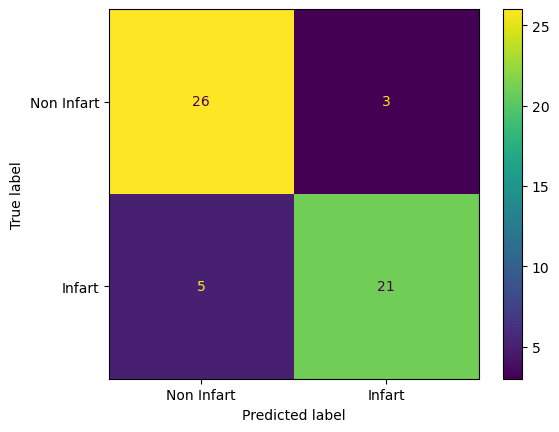

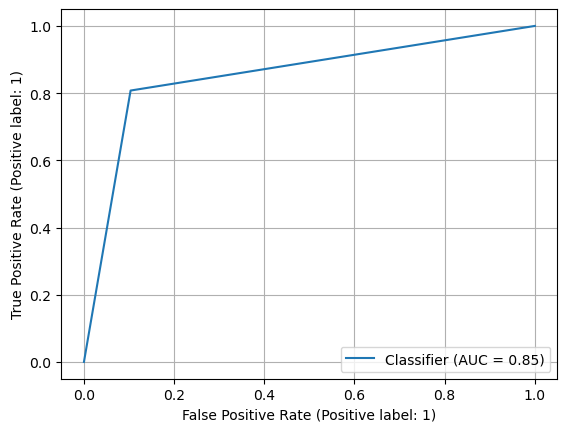

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




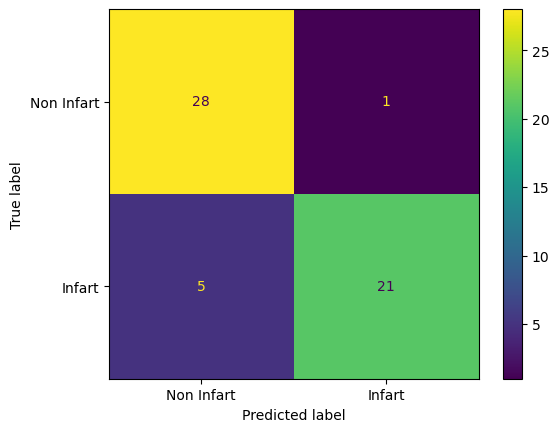

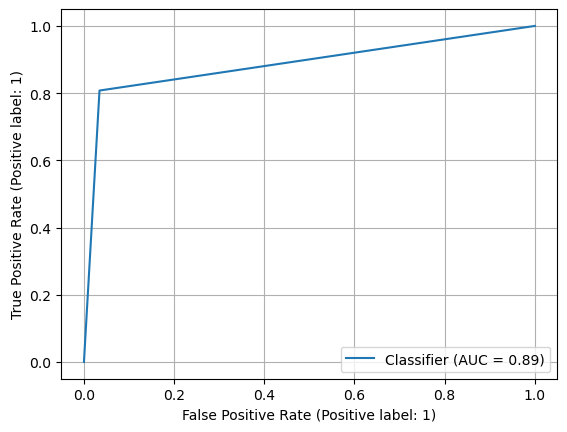

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




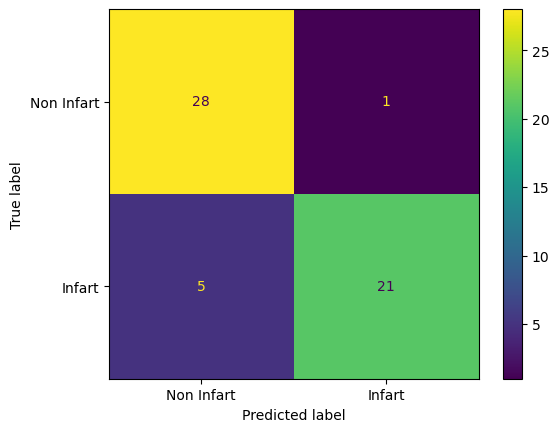

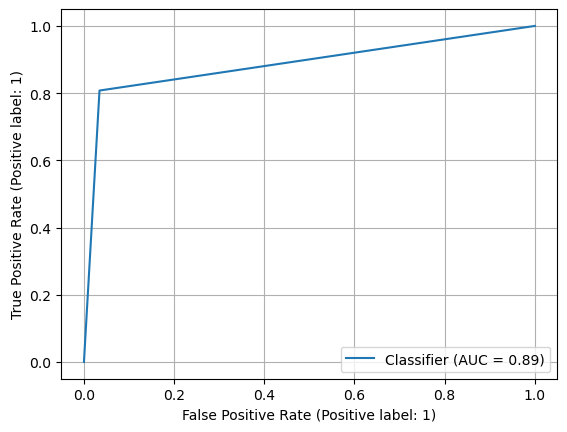

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




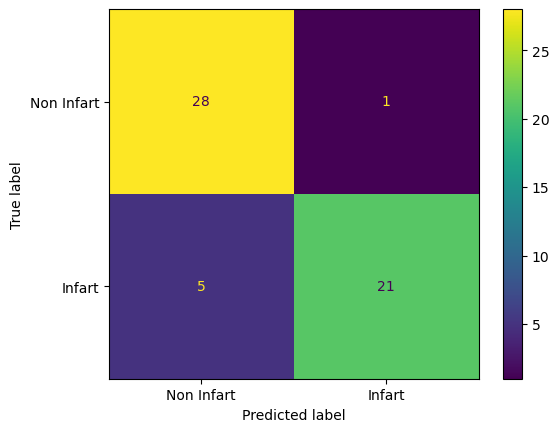

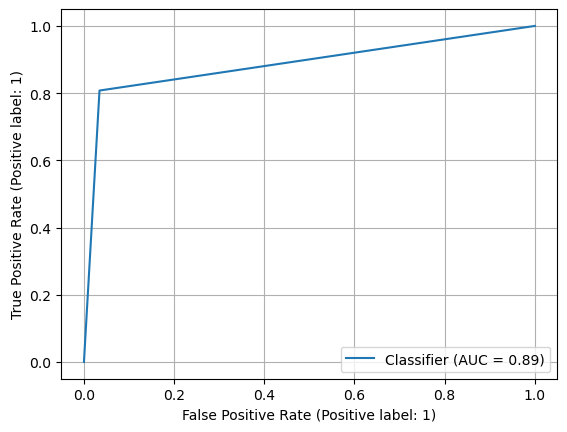

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




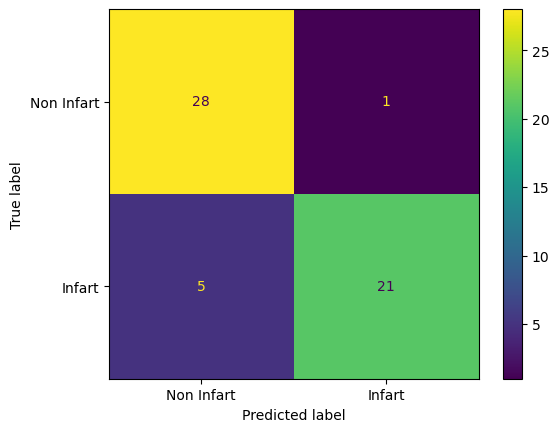

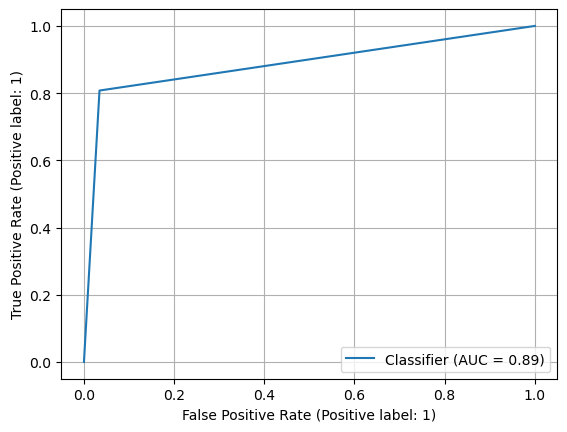

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




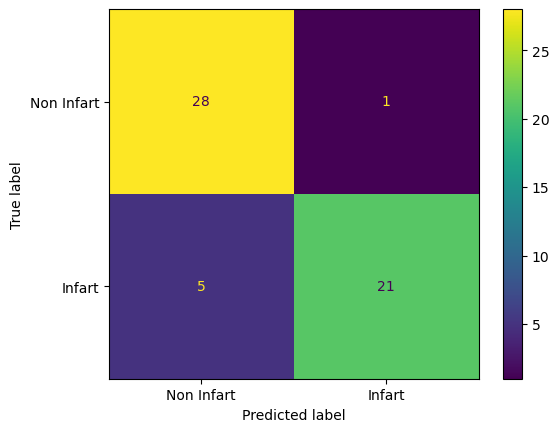

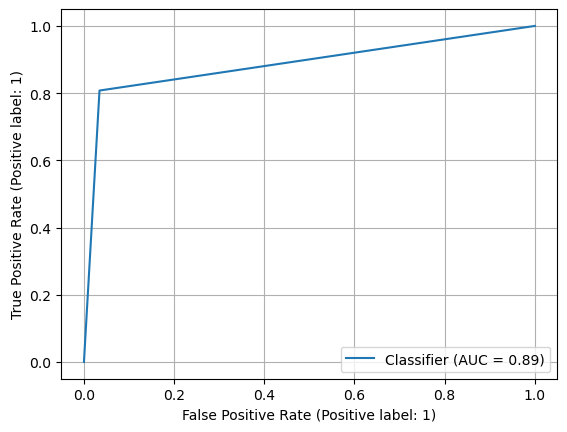

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




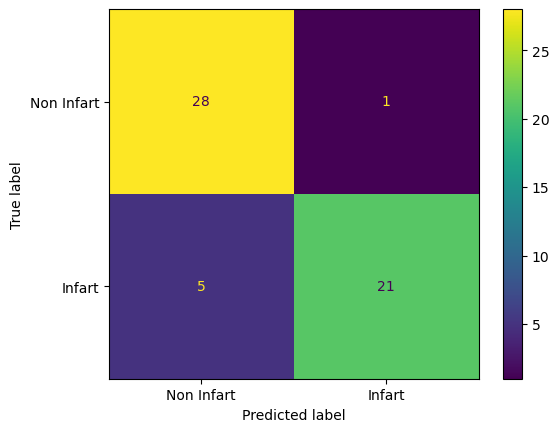

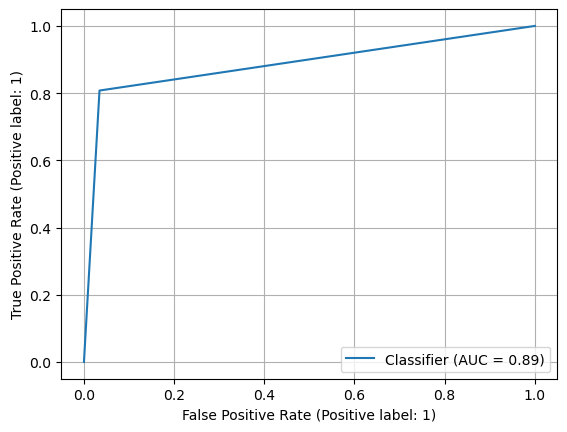

Number of samples: 55
Specificity= 0.896551724137931
Sensibility= 0.8076923076923077
False positive rate = 0.10344827586206895




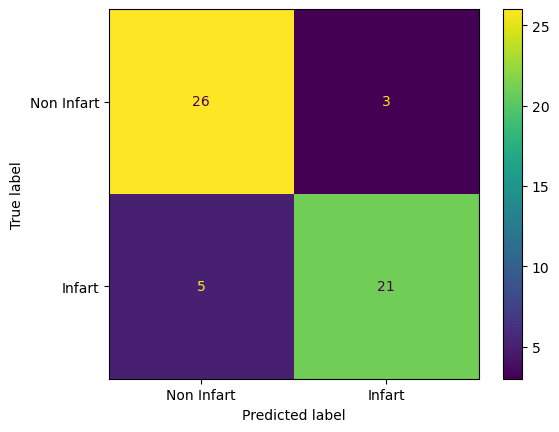

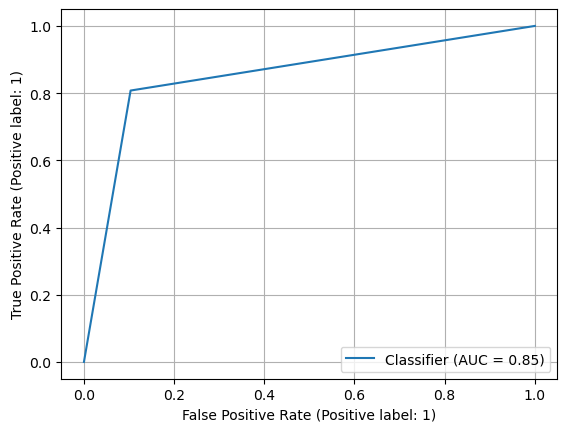

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077
False positive rate = 0.06896551724137934




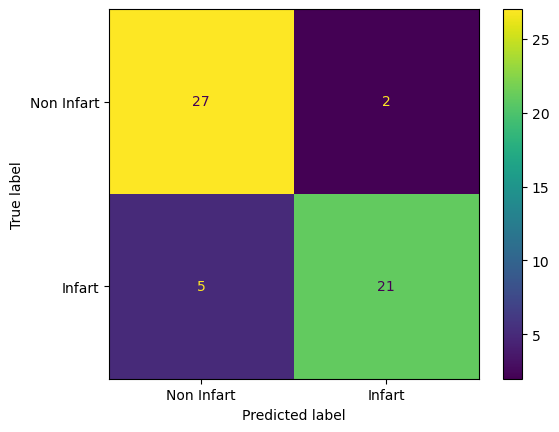

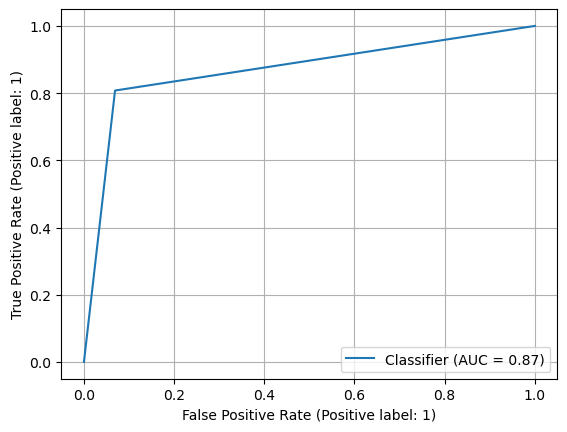

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077
False positive rate = 0.06896551724137934




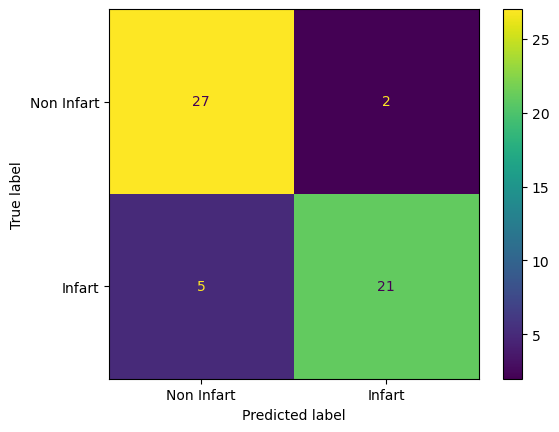

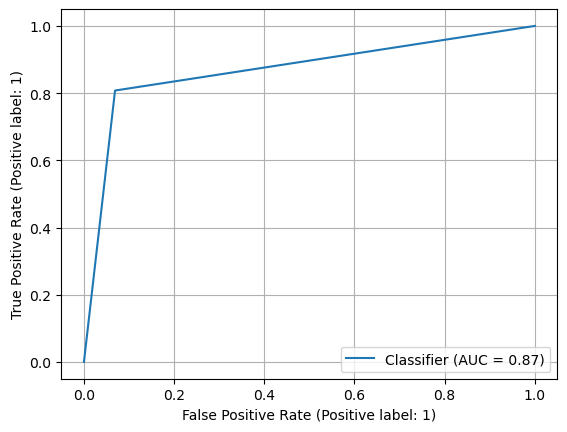

Number of samples: 55
Specificity= 0.896551724137931
Sensibility= 0.8076923076923077
False positive rate = 0.10344827586206895




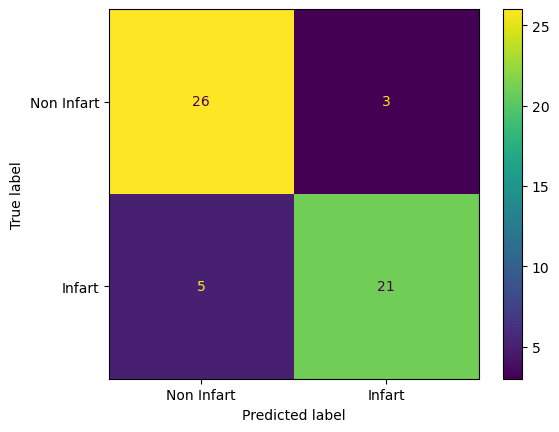

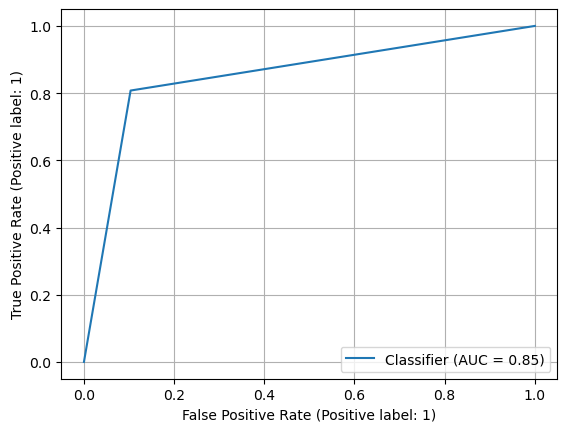

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




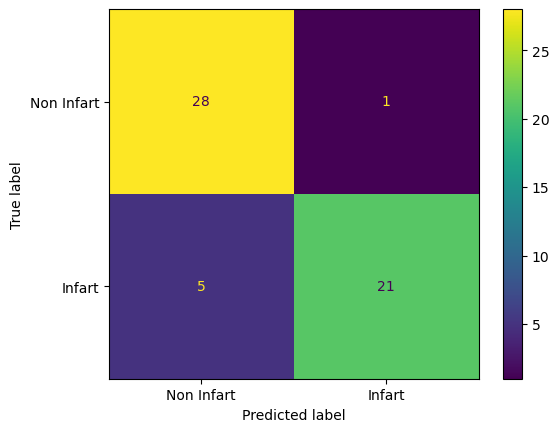

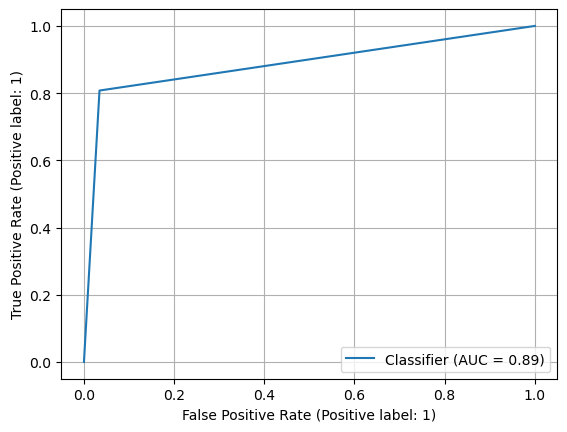

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




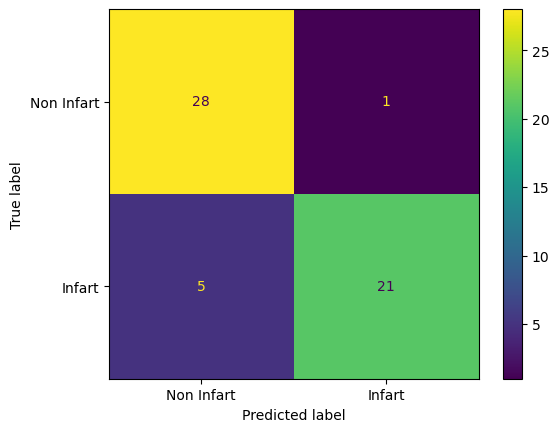

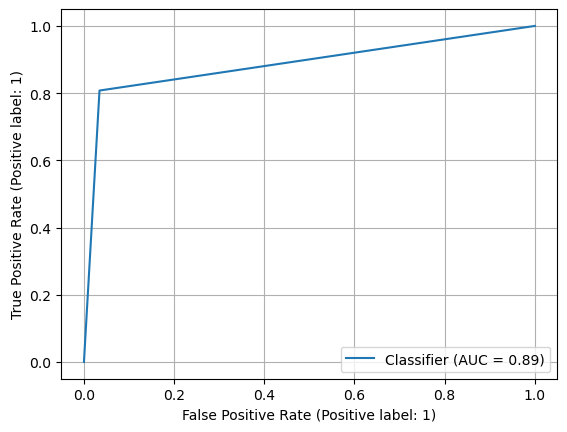

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




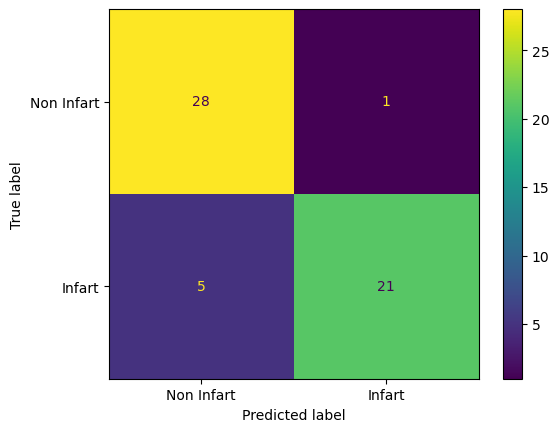

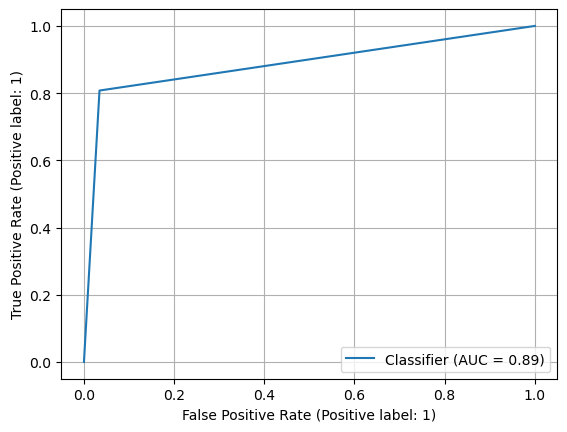

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




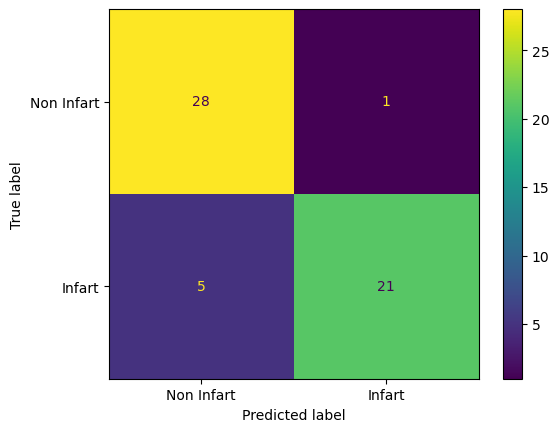

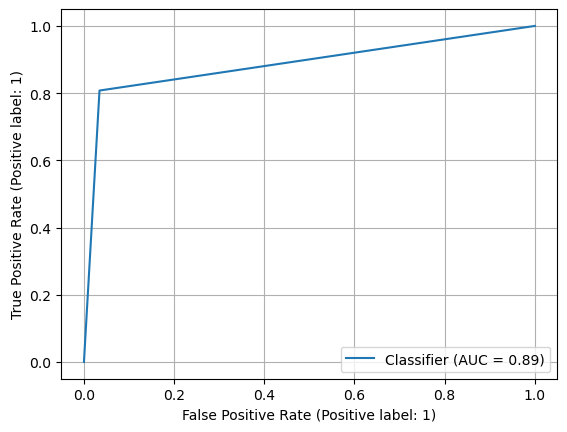

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




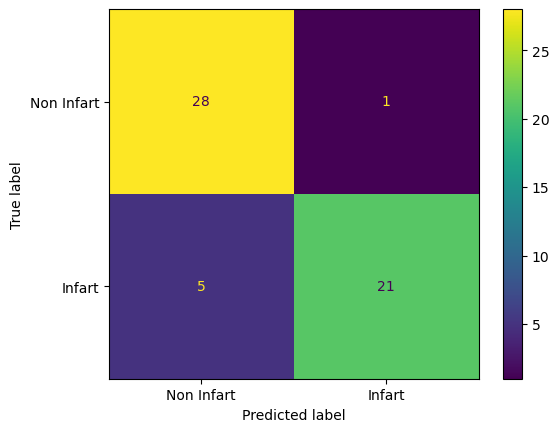

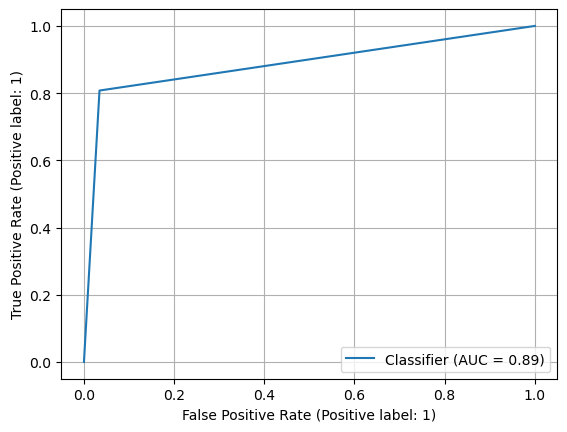

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




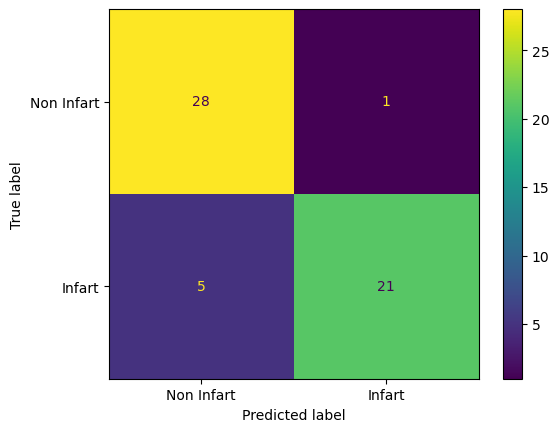

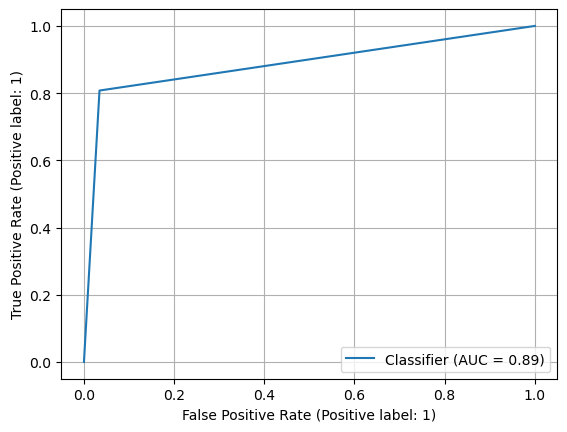

Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077
False positive rate = 0.06896551724137934




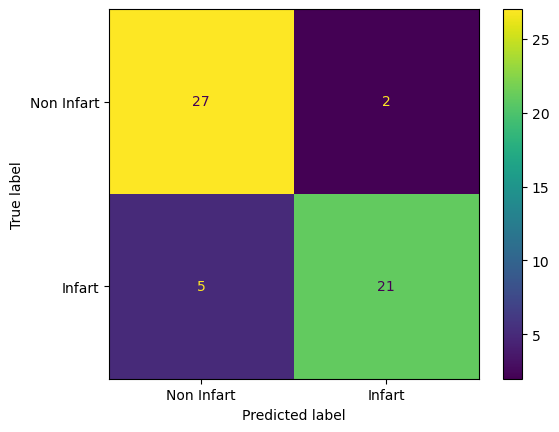

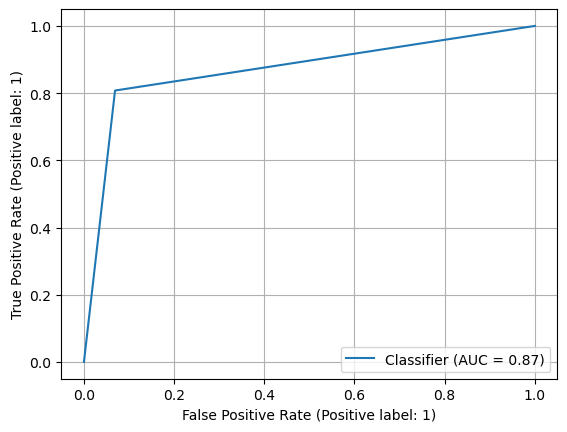

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




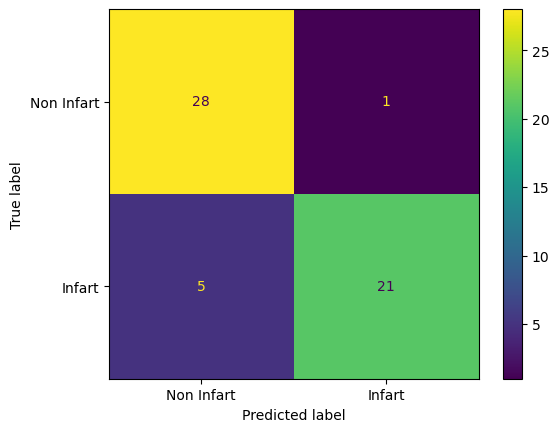

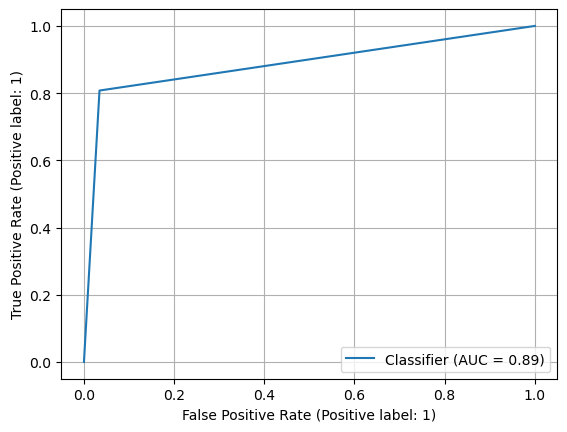

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




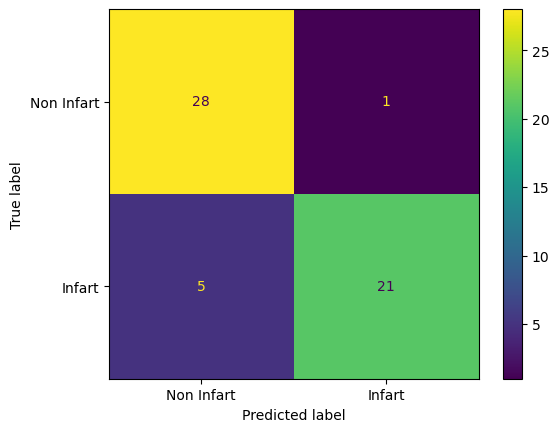

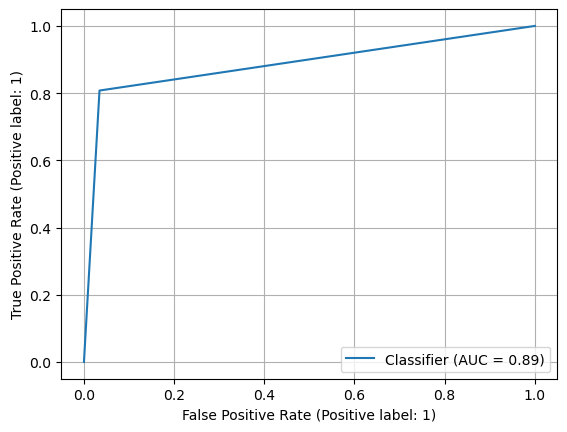

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




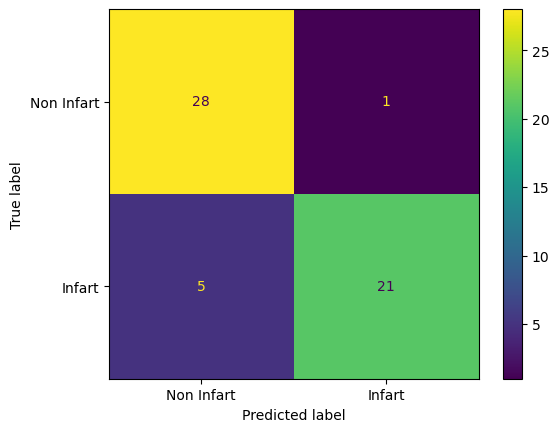

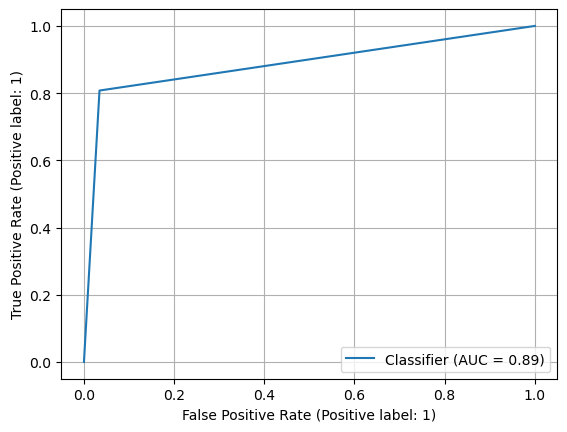

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




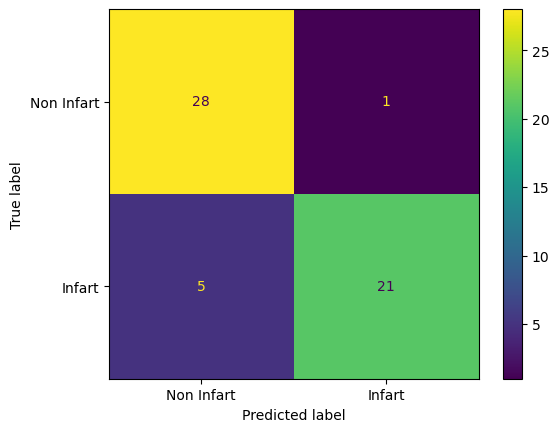

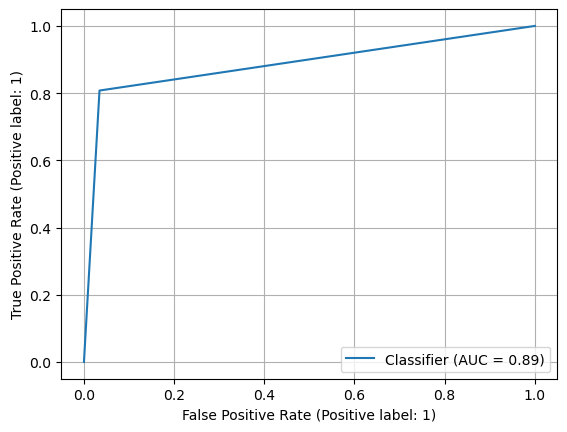

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




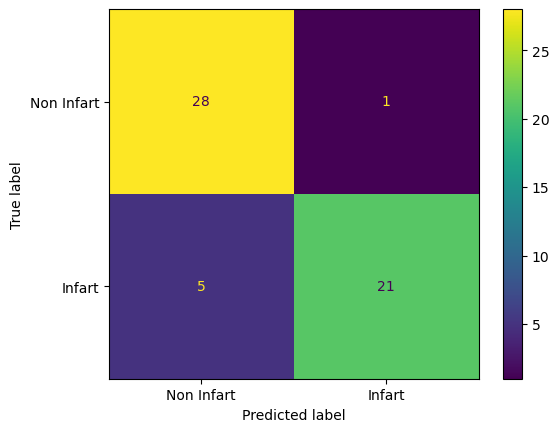

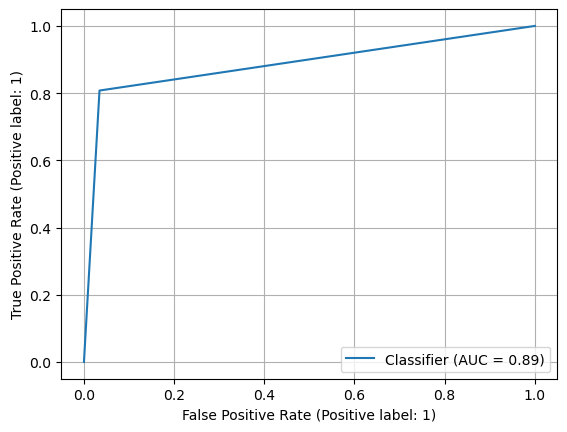

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




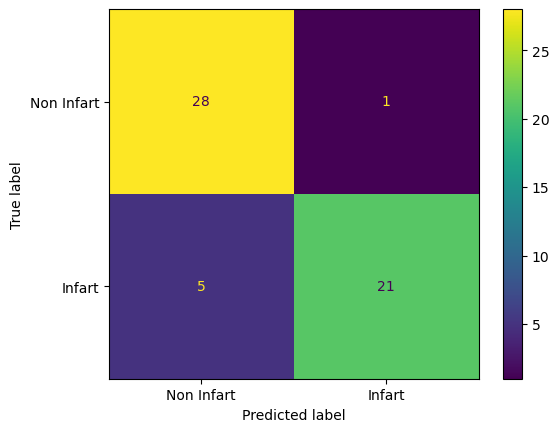

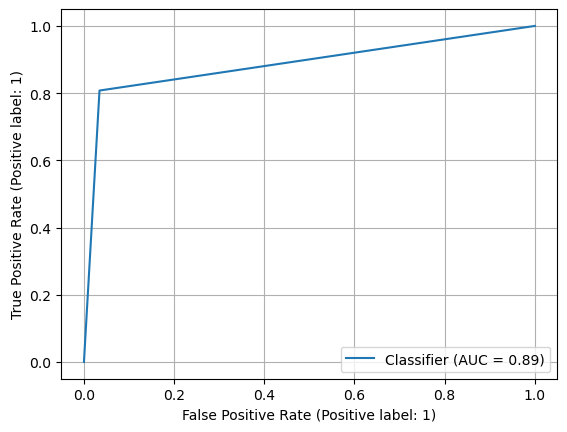

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




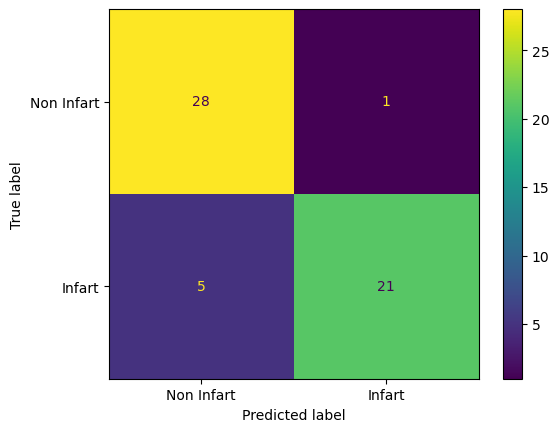

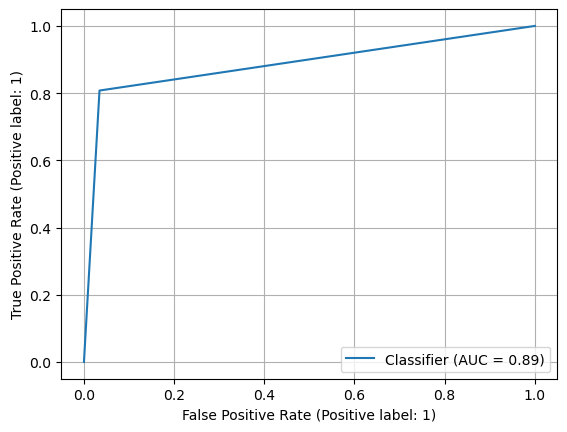

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




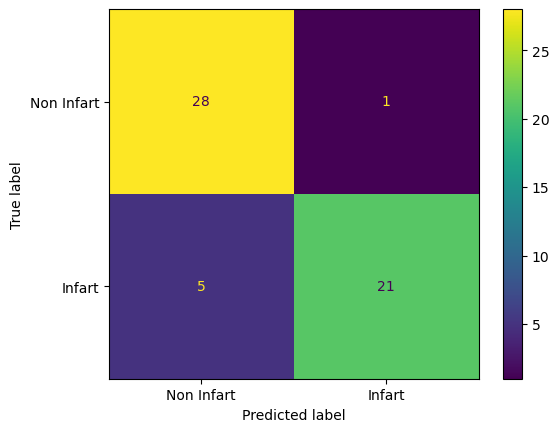

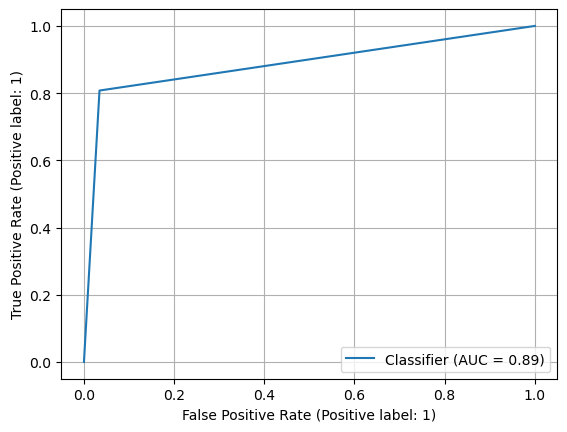

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




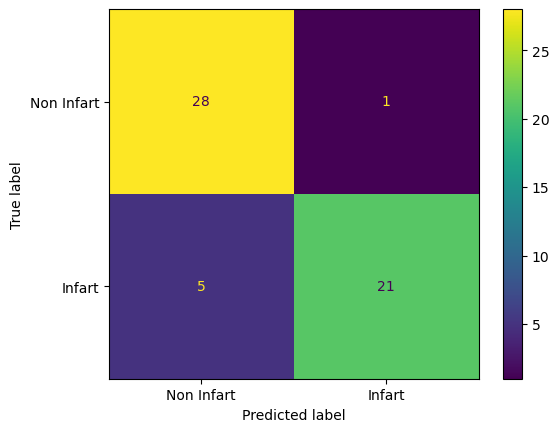

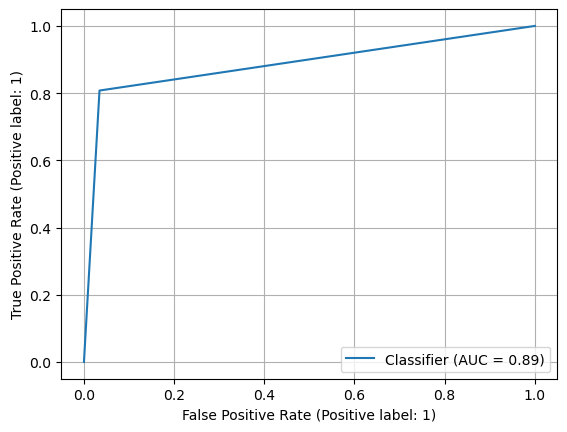

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




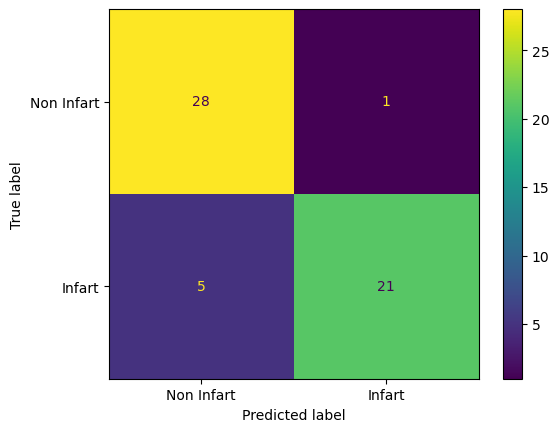

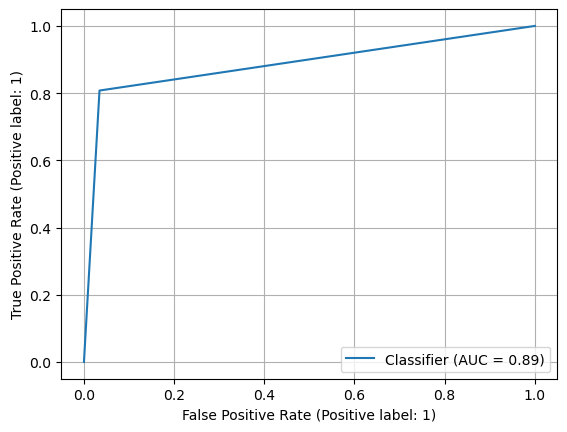

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




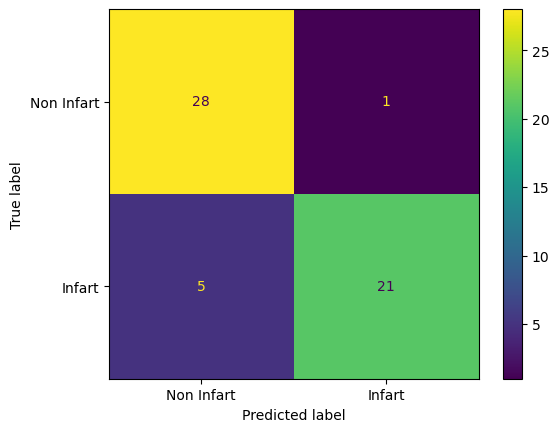

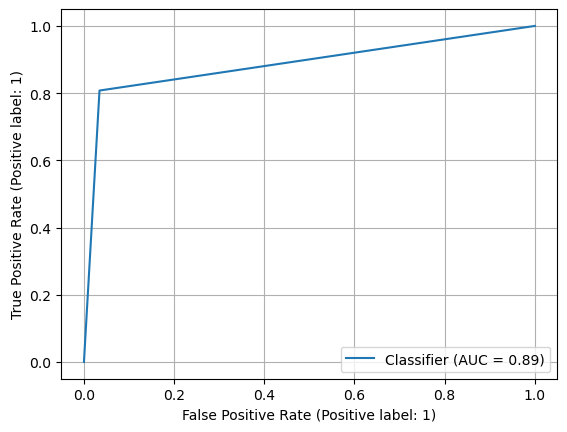

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




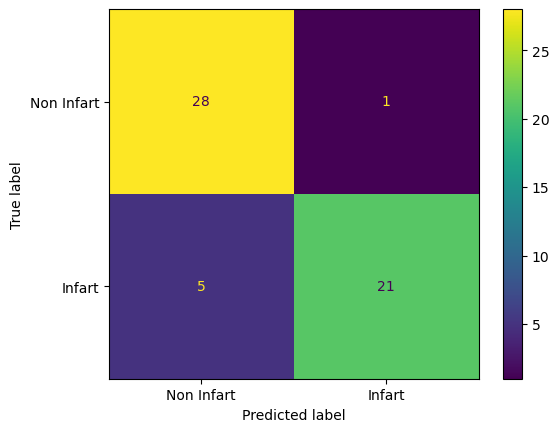

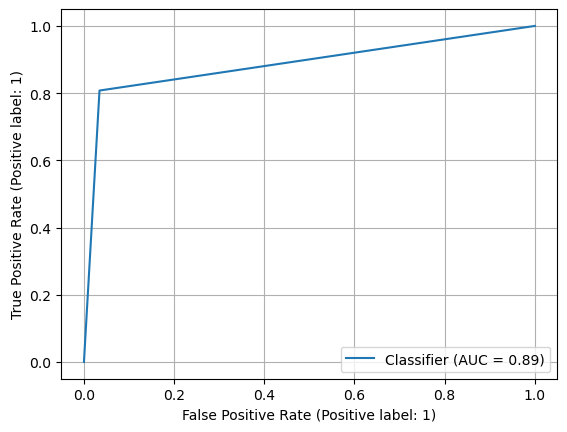

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




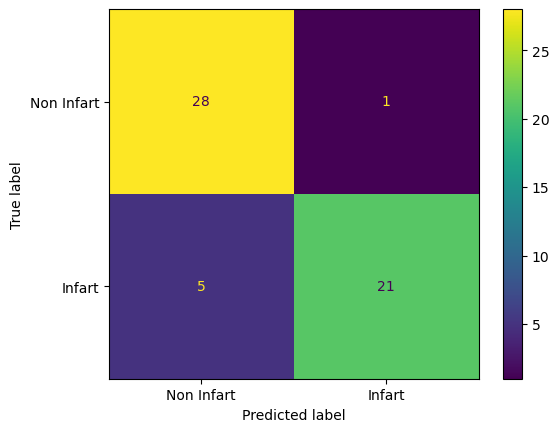

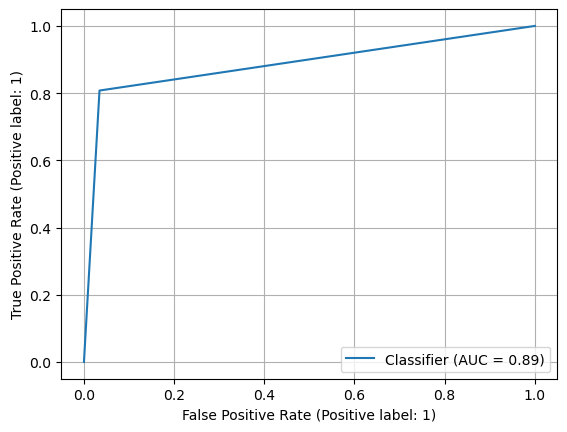

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




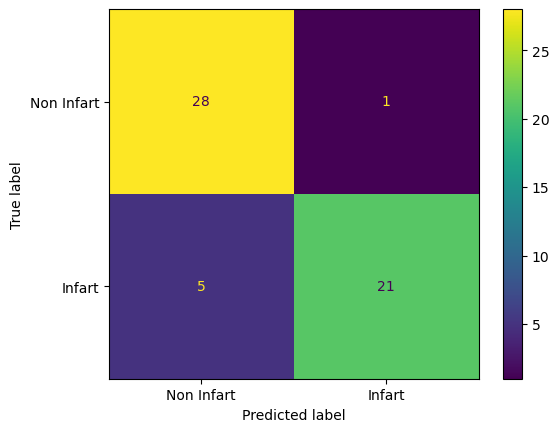

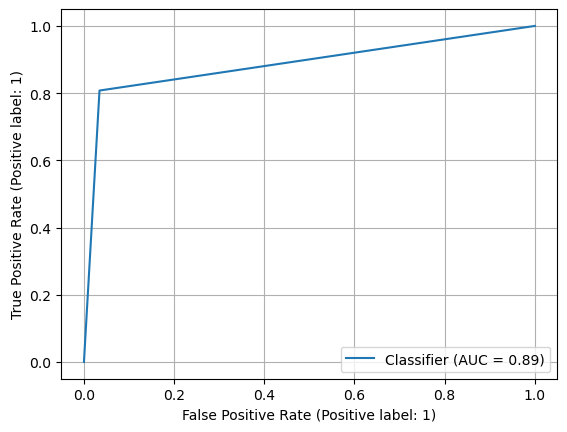

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




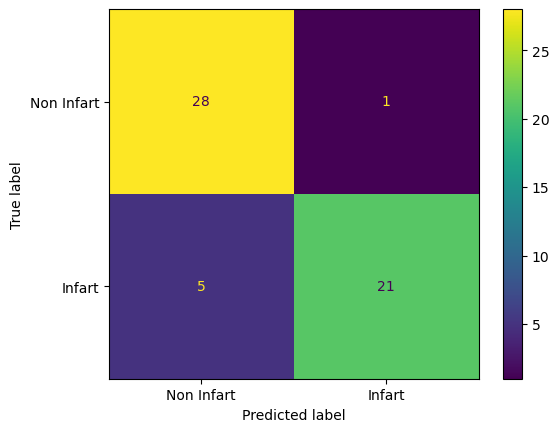

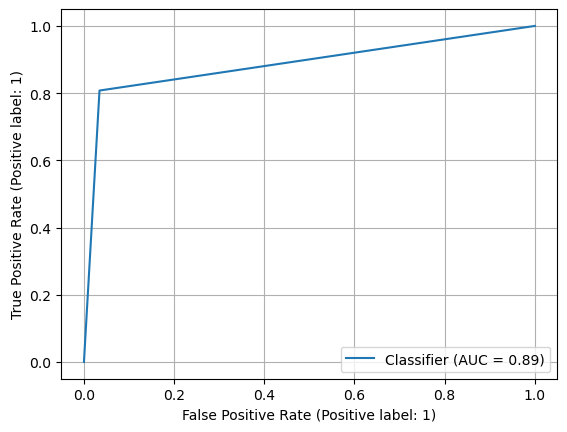

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




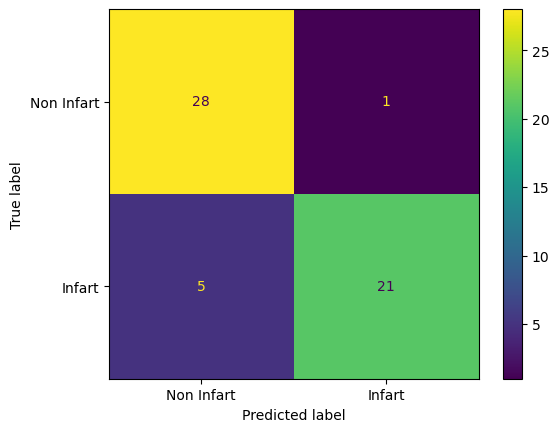

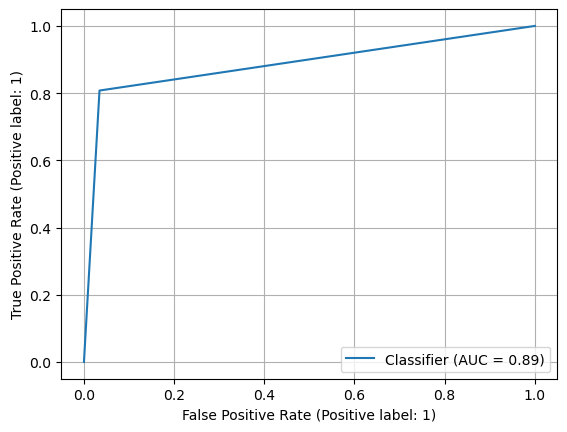

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




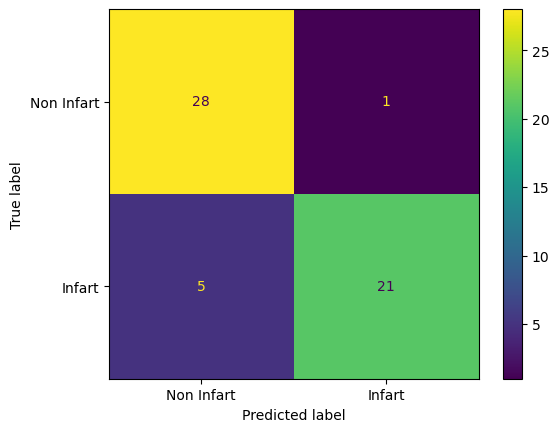

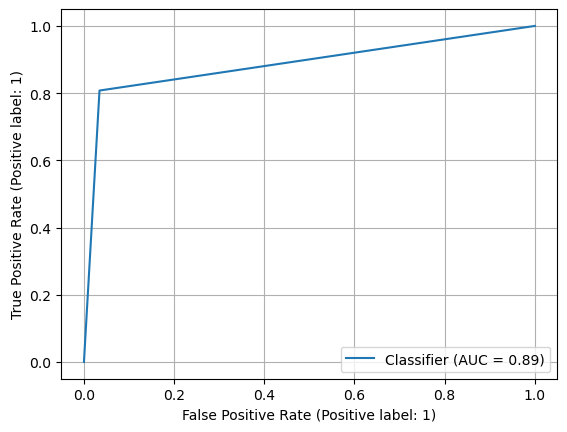

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




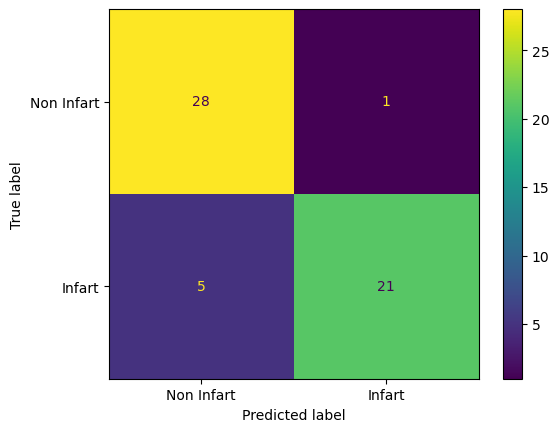

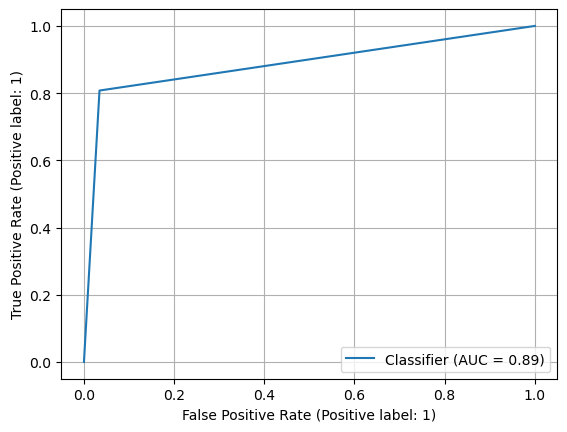

Number of samples: 55
Specificity= 0.896551724137931
Sensibility= 0.8076923076923077
False positive rate = 0.10344827586206895




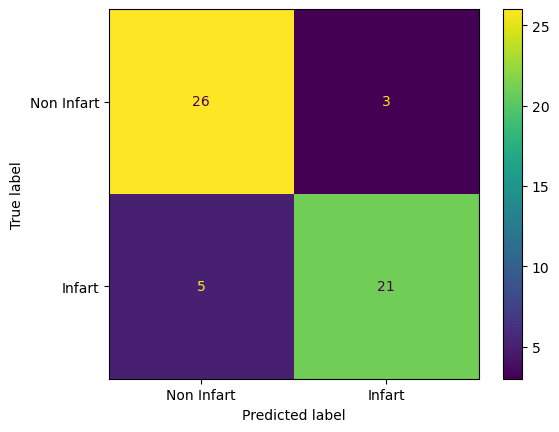

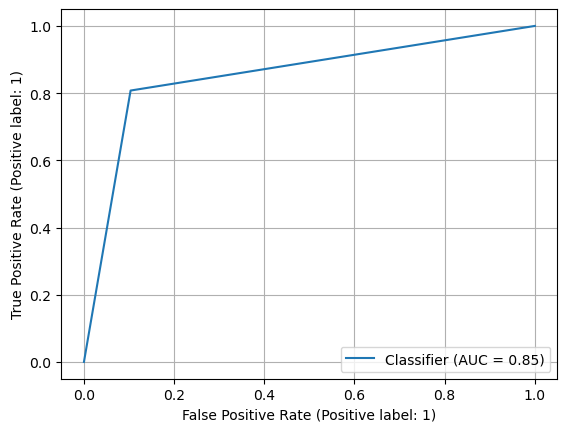

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




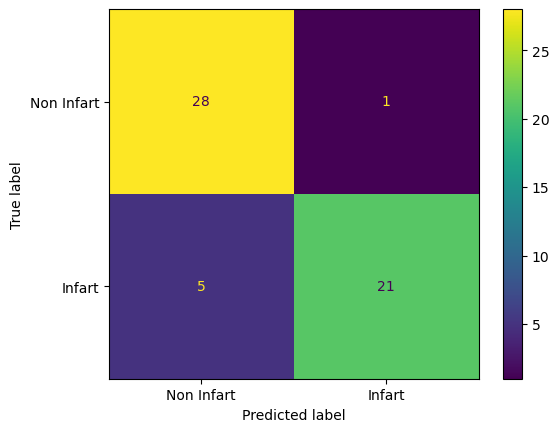

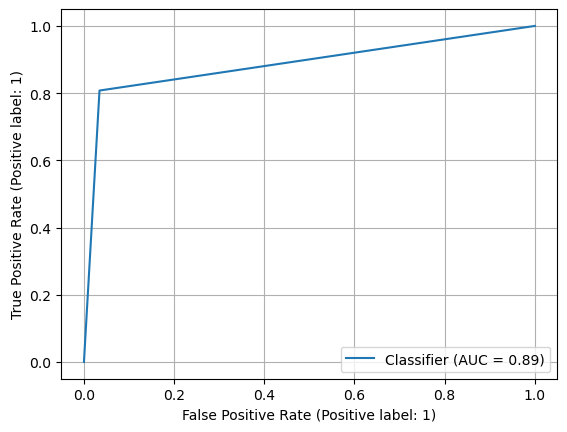

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




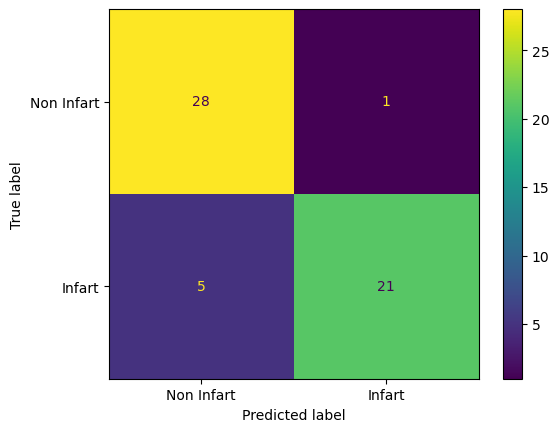

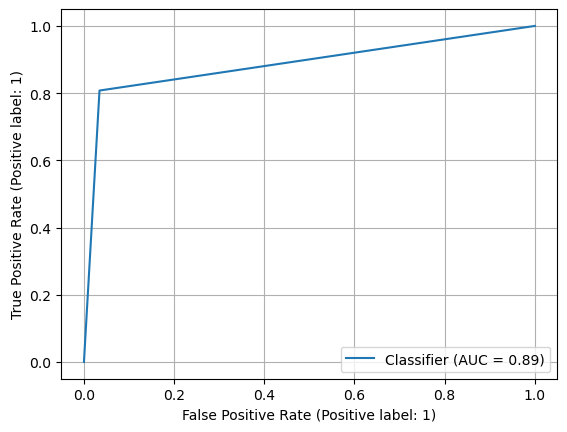

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




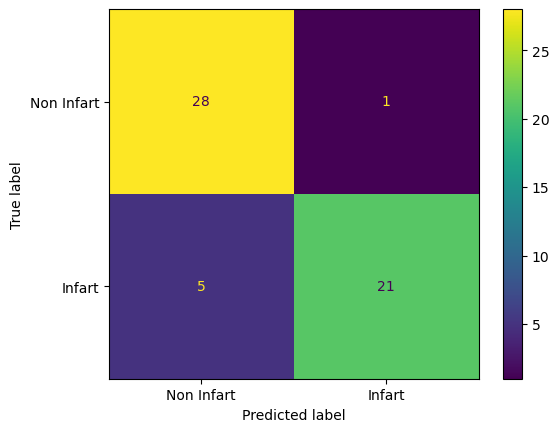

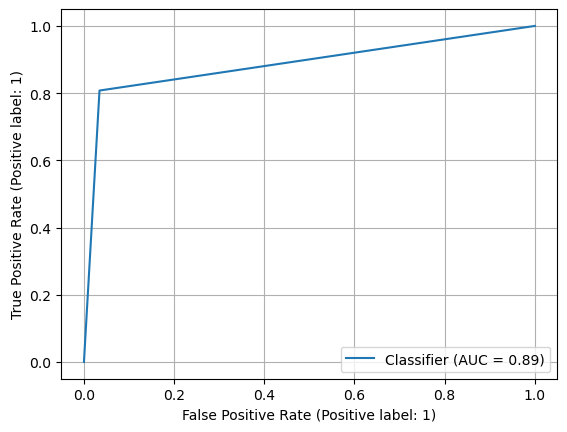

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




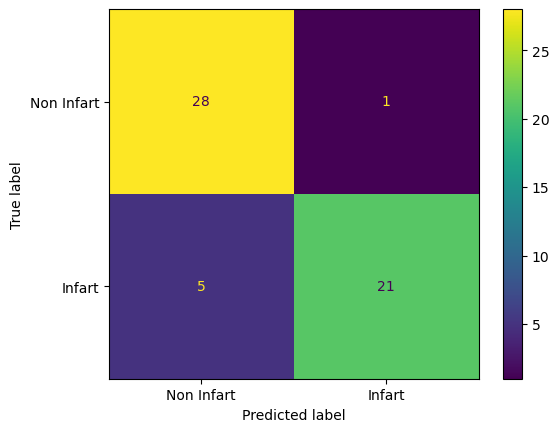

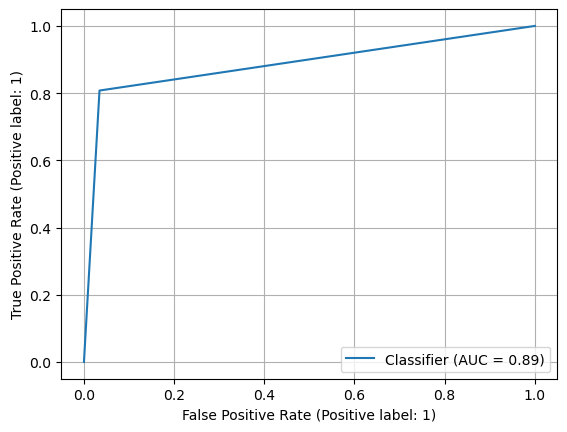

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




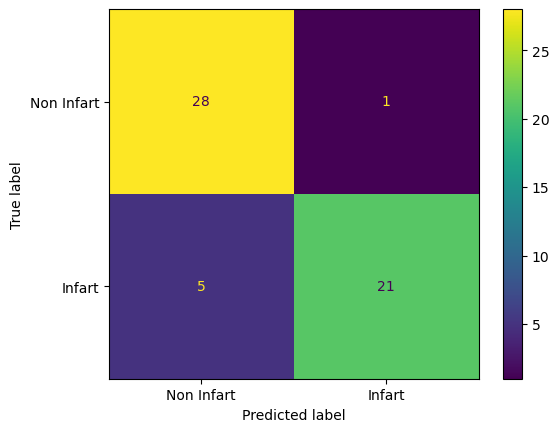

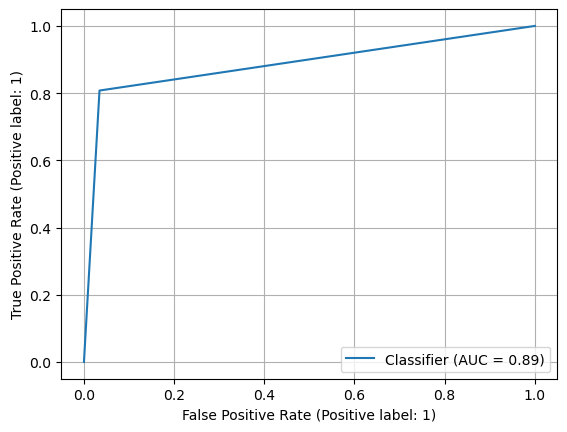

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




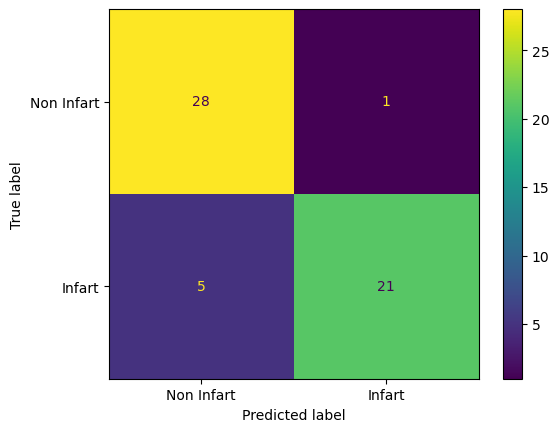

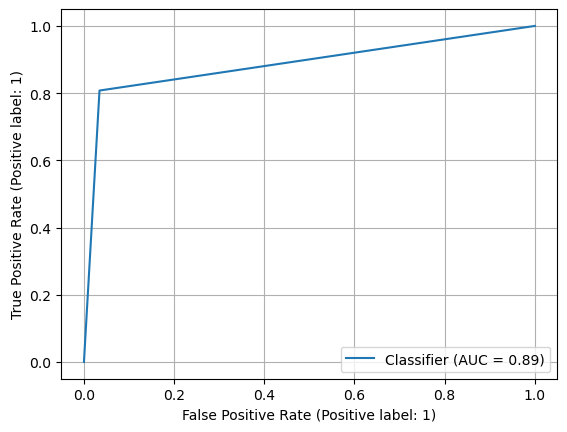

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




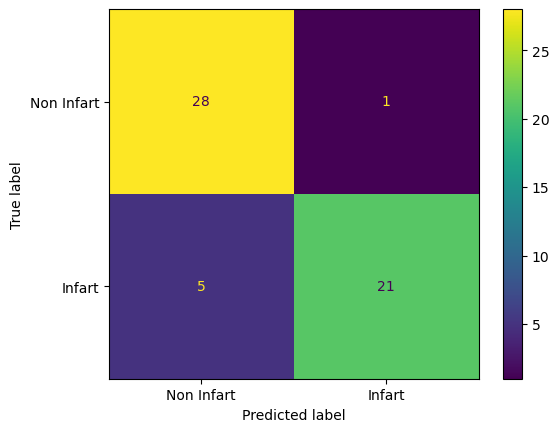

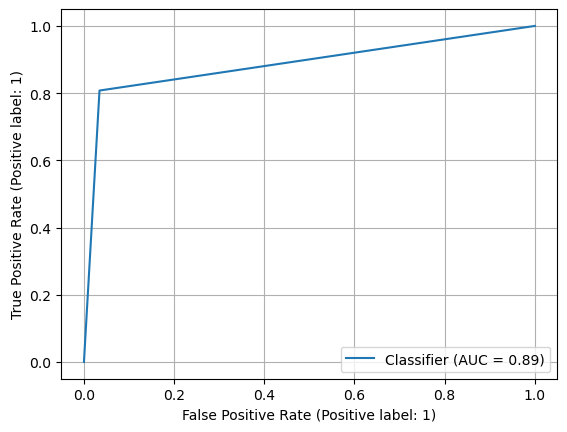

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077
False positive rate = 0.03448275862068961




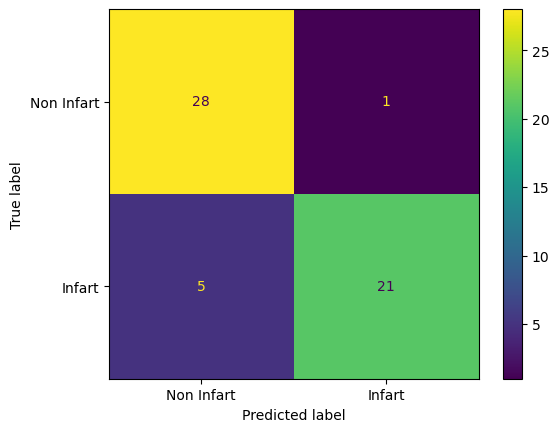

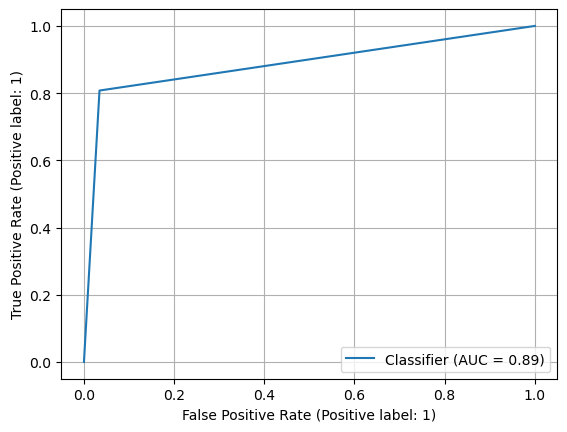

Mean Specificity= 0.9561128526645768 Std: 0.021261222517634078
Mean Sensibility= 0.8076923076923075  Std: 2.220446049250313e-16
Mean False Positive Rate= 0.04388714733542315  Std: 0.021261222517634085


In [41]:
model = KNeighborsClassifier()
estimators = evaluate_model(model, X_train, y.values, cv)
evaluate_kfold(estimators, X_train, y.values)

Accuracy: 0.7272727272727273


Fold 0
Number of samples: 11
Mean Specificity= 0.6666666666666666
Mean Sensibility= 1.0




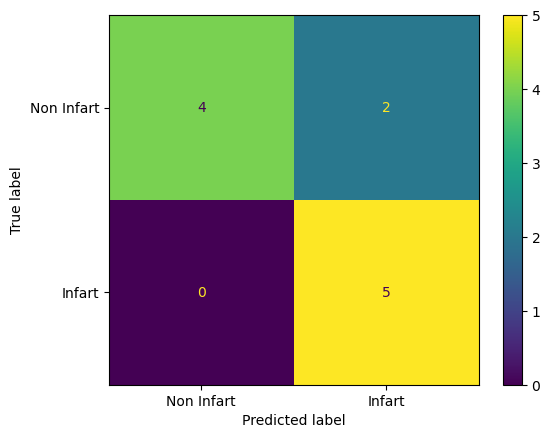

Fold 1
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




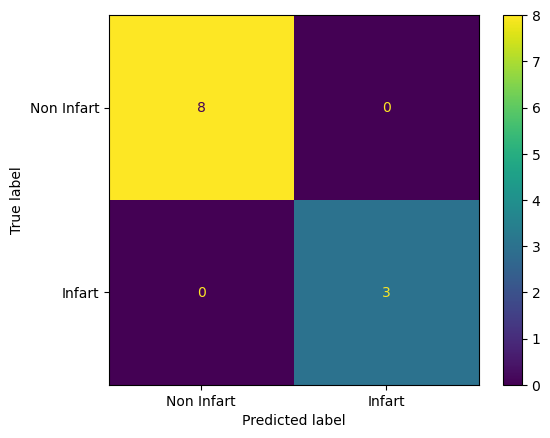

Fold 2
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




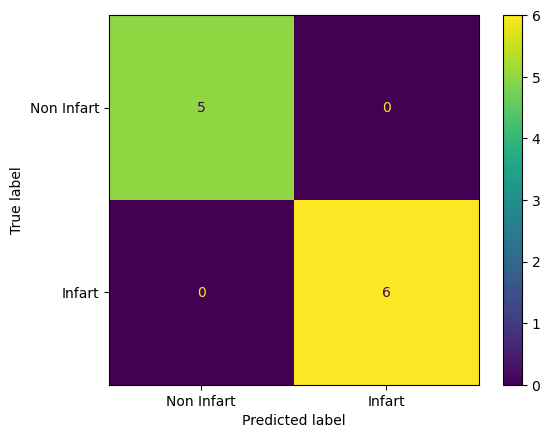

Fold 3
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




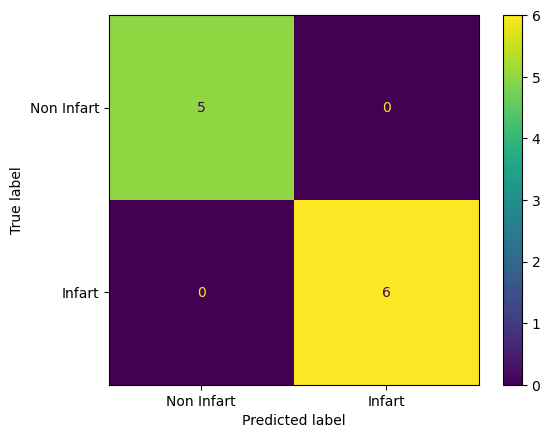

Fold 4
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




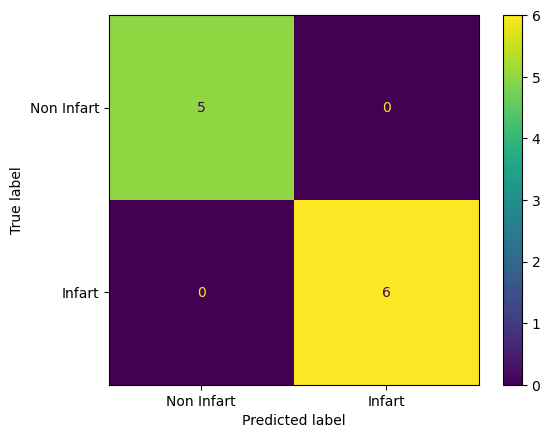

Mean Specificity= 0.9333333333333332 Std: 0.13333333333333336
Mean Sensibility= 1.0  Std: 0.0
Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 1.0




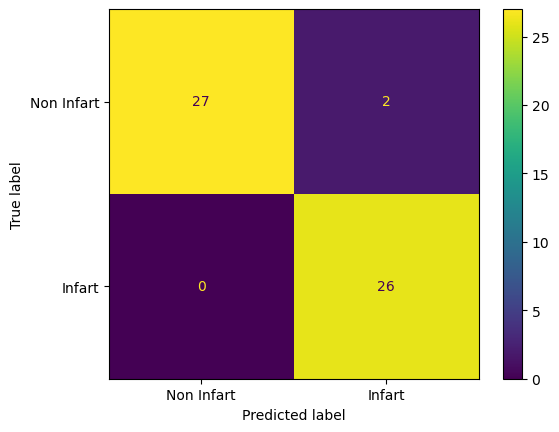

Number of samples: 55
Specificity= 0.8275862068965517
Sensibility= 1.0




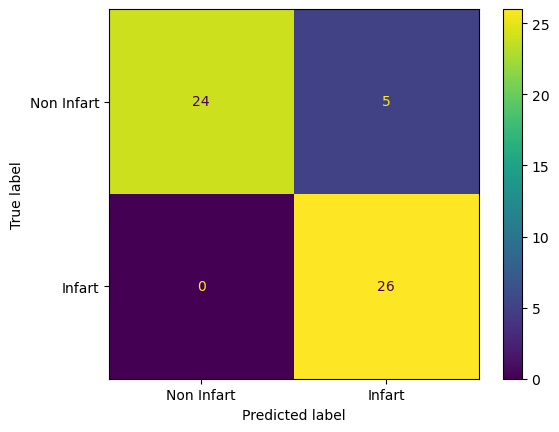

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.9615384615384616




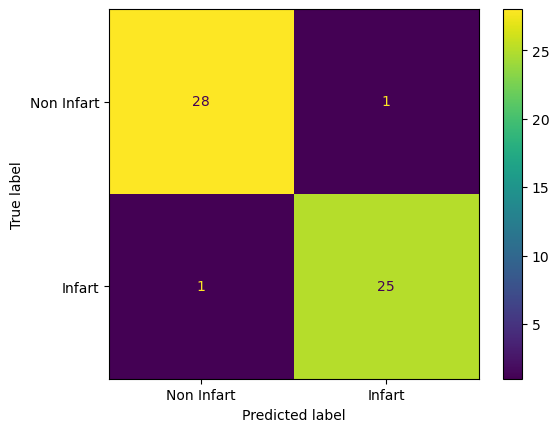

Number of samples: 55
Specificity= 1.0
Sensibility= 0.8461538461538461




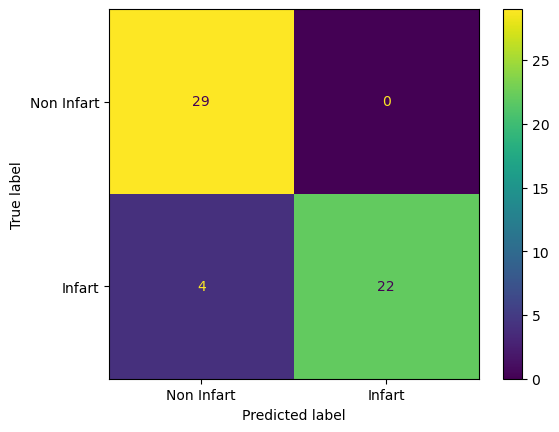

Number of samples: 55
Specificity= 1.0
Sensibility= 0.9230769230769231




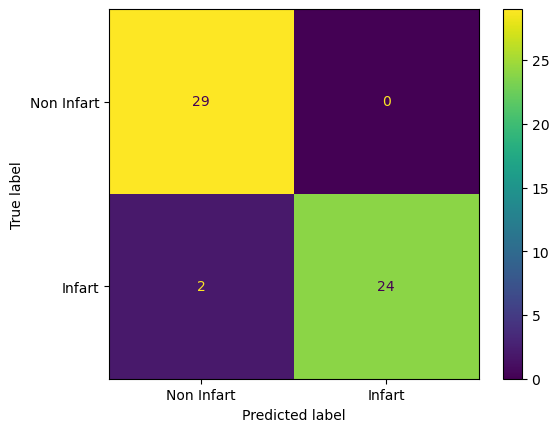

Mean Specificity= 0.9448275862068964 Std: 0.06395598962410831
Mean Sensibility= 0.9461538461538461  Std: 0.05756395979652218


In [31]:
model = DecisionTreeClassifier()
estimators = evaluate_model(model, X_train, y.values, cv)
evaluate_kfold(estimators, X_total=X_train, y_total=y.values)

Accuracy: 0.8181818181818181


Fold 0
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 1.0




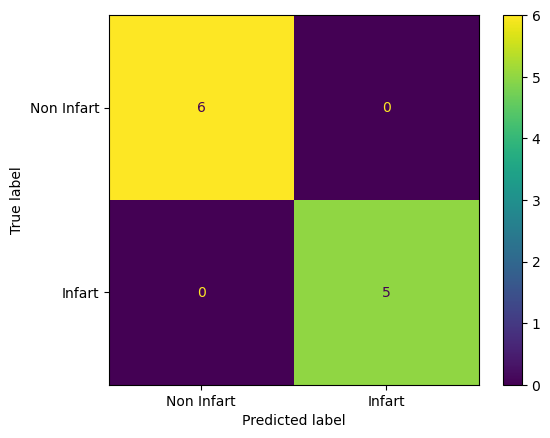

Fold 1
Number of samples: 11
Mean Specificity= 0.875
Mean Sensibility= 0.6666666666666666




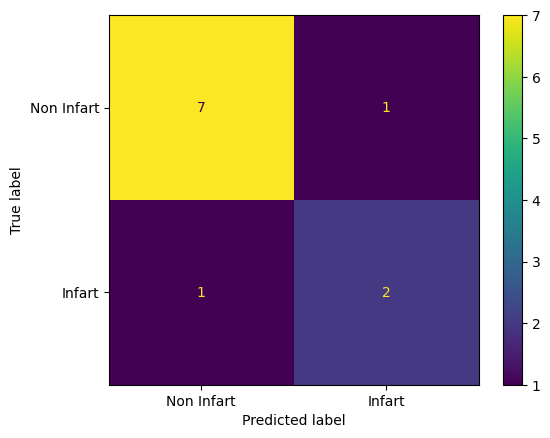

Fold 2
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 0.8333333333333334




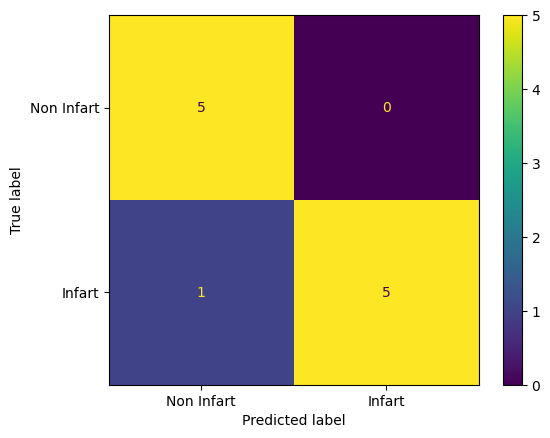

Fold 3
Number of samples: 11
Mean Specificity= 0.8
Mean Sensibility= 0.8333333333333334




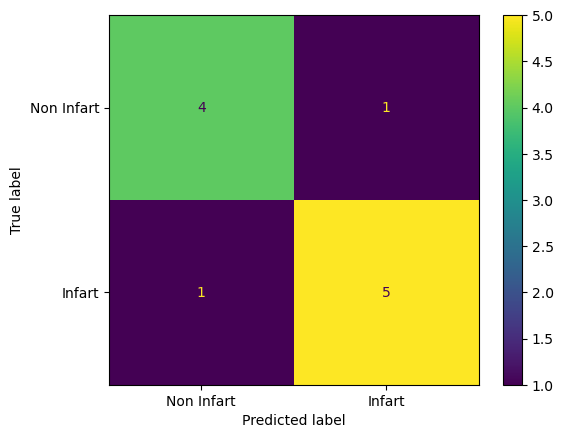

Fold 4
Number of samples: 11
Mean Specificity= 1.0
Mean Sensibility= 0.6666666666666666




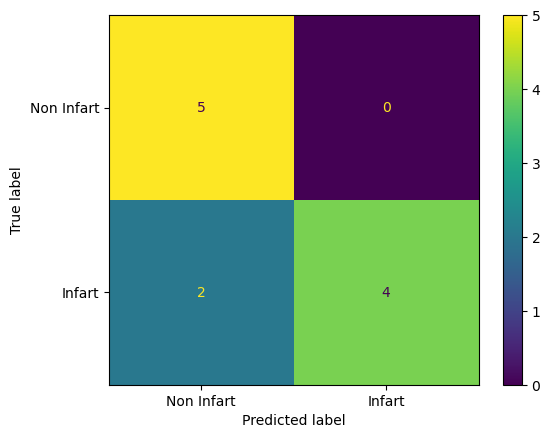

Mean Specificity= 0.9349999999999999 Std: 0.08306623862918074
Mean Sensibility= 0.8  Std: 0.12472191289246473
Number of samples: 55
Specificity= 0.9310344827586207
Sensibility= 0.8076923076923077




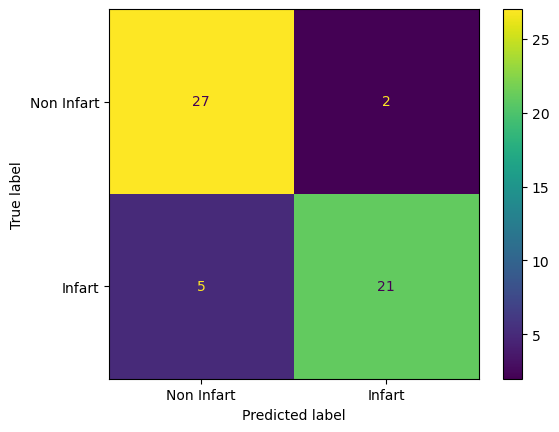

Number of samples: 55
Specificity= 0.8275862068965517
Sensibility= 0.8846153846153846




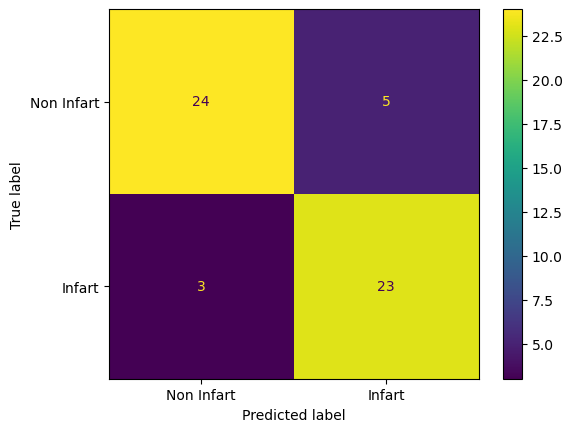

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.7692307692307693




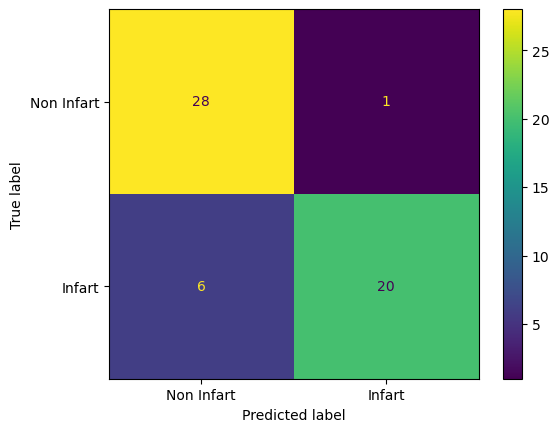

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.7692307692307693




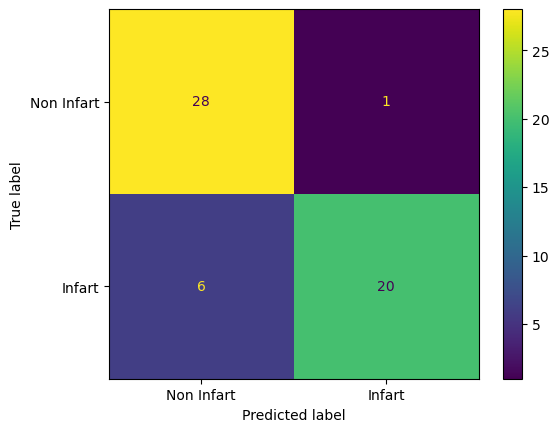

Number of samples: 55
Specificity= 0.9655172413793104
Sensibility= 0.8076923076923077




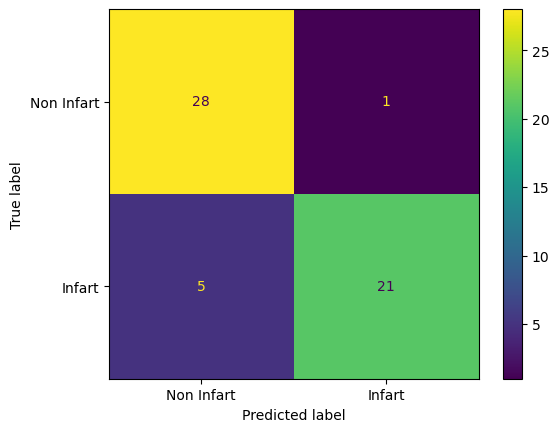

Mean Specificity= 0.9310344827586207 Std: 0.05342045994768853
Mean Sensibility= 0.8076923076923077  Std: 0.042132504423474285


In [33]:
model = SVC()
estimators = evaluate_model(model, X_train, y.values, cv)
evaluate_kfold(estimators, X_total=X_train, y_total=y.values)